In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates


import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.gnn import create_features, create_label
from spektral.layers import GCNConv
from spektral.utils import gcn_filter

2024-04-28 18:57:04.823349: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 18:57:05.158541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 18:57:05.158737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 18:57:05.189611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 18:57:05.262615: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
id_column = "WHO_region"
df = pd.read_csv(file_path)[[date_column, target_column, id_column]]
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column, id_column])[target_column].sum().reset_index()
unique_dates = df[date_column].unique()
um_countries_regions = len(df[id_column].unique())
df.head()

,Date_reported,WHO_region,New_deaths
0,2020-02-02,AFRO,49.0
1,2020-02-02,AMRO,56.0
2,2020-02-02,EMRO,22.0
3,2020-02-02,EURO,65.0
4,2020-02-02,Other,1.0


In [3]:
# pivot_df = df.pivot_table(index=date_column, columns=id_column, values=target_column)

df.rename(columns={"index": date_column}, inplace=True)
df.head()


,Date_reported,WHO_region,New_deaths
0,2020-02-02,AFRO,49.0
1,2020-02-02,AMRO,56.0
2,2020-02-02,EMRO,22.0
3,2020-02-02,EURO,65.0
4,2020-02-02,Other,1.0


In [4]:
unstaked_df = df.copy()
unstaked_df["id"] = unstaked_df["WHO_region"]
unstaked_df.set_index(["id", "Date_reported"], inplace=True)

# Dropping columns not needed for the analysis
unstaked_df.drop(["WHO_region"], axis=1, inplace=True)

# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, :15].head()

(7, 1390)


Date_reported,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16
id,,,,,,,,,,,,,,,
AFRO,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
AMRO,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
EMRO,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
EURO,65.0,62.0,63.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,63.0
Other,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14

In [6]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = unique_dates[0]
valid_date = unique_dates[int(len(unique_dates) *0.8)+1]
test_date = unique_dates[int(len(unique_dates) *0.9)]

In [59]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date + timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_train_seq = np.concatenate(X_seq, axis=0)
X_train_cor = np.concatenate(X_cor, axis=0)
X_train_feat = np.concatenate(X_feat, axis=0)
y_train = np.concatenate(y, axis=0)

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

  1%|          | 9/1100 [00:00<00:12, 85.04it/s]

[[ 49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.]
 [ 56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  56.]
 [ 22.  22.  22.  22.  22.  22.  22.  22.  22.  22.  22.  22.  22.  22.]
 [ 65.  62.  63.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.]
 [138.  99. 101. 107. 105. 120. 122. 135. 142. 135.  40. 288. 187. 177.]]
[[ 49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.]
 [ 56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  56.]
 [ 22.  22.  22.  22.  22.  22.  22.  22.  22.  22.  22.  22.  22.  22.]
 [ 62.  63.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  62.  63.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.]
 [ 99. 101. 107. 105. 120. 122. 135. 142. 135.  40

  2%|▏         | 27/1100 [00:00<00:15, 71.16it/s]

[[ 49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.]
 [ 56.  56.  56.  56.  56.  56.  56.  56.  56.  56.  57.  56.  57.  56.]
 [ 22.  22.  24.  24.  23.  25.  26.  25.  26.  29.  30.  31.  33.  34.]
 [ 62.  62.  62.  62.  65.  64.  66.  65.  64.  67.  66.  71.  68.  80.]
 [  1.   3.   1.   1.   1.   2.   2.   1.   1.   2.   2.   1.   1.   1.]
 [ 11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  12.  11.  11.]
 [148. 158.  35. 242.  37. 189. 106.  91.  67.  80.  86.  72.  84.  73.]]
[[ 49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.]
 [ 56.  56.  56.  56.  56.  56.  56.  56.  56.  57.  56.  57.  56.  62.]
 [ 22.  24.  24.  23.  25.  26.  25.  26.  29.  30.  31.  33.  34.  33.]
 [ 62.  62.  62.  65.  64.  66.  65.  64.  67.  66.  71.  68.  80.  91.]
 [  3.   1.   1.   1.   2.   2.   1.   1.   2.   2.   1.   1.   1.   1.]
 [ 11.  11.  11.  11.  11.  11.  11.  11.  11.  11.  12.  11.  11.  11.]
 [158.  35. 242.  37. 189. 106.  91.  67.  80.  86

  3%|▎         | 35/1100 [00:00<00:17, 60.19it/s]

[[ 49.  49.  49.  54.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.]
 [ 57.  56.  62.  60.  59.  59.  59.  61.  64.  60.  65.  73.  65.  68.]
 [ 33.  34.  33.  37.  39.  39.  43.  75.  67.  77.  89.  99. 109. 118.]
 [ 68.  80.  91.  90. 106. 113. 141. 198. 164. 238. 272. 271. 337. 901.]
 [  1.   1.   1.   1.   1.   1.   2.   1.   1.   1.   1.   1.   1.   1.]
 [ 11.  11.  11.  11.  11.  11.  11.  11.  11.  12.  11.  13.  14.  11.]
 [ 84.  73.  76.  70.  71.  66.  70.  63.  54.  68.  54.  50.  61.  52.]]
[[ 49.  49.  54.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.]
 [ 56.  62.  60.  59.  59.  59.  61.  64.  60.  65.  73.  65.  68.  74.]
 [ 34.  33.  37.  39.  39.  43.  75.  67.  77.  89.  99. 109. 118. 135.]
 [ 80.  91.  90. 106. 113. 141. 198. 164. 238. 272. 271. 337. 901. 474.]
 [  1.   1.   1.   1.   1.   2.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 11.  11.  11.  11.  11.  11.  11.  11.  12.  11.  13.  14.  11.  12.]
 [ 73.  76.  70.  71.  66.  70.  63.  54.  68.  54

  4%|▍         | 48/1100 [00:00<00:19, 54.32it/s]

[[4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01
  4.900e+01 5.000e+01 4.900e+01 5.200e+01 5.200e+01 5.300e+01 5.000e+01]
 [6.000e+01 6.500e+01 7.300e+01 6.500e+01 6.800e+01 7.400e+01 7.800e+01
  8.300e+01 9.400e+01 1.390e+02 1.330e+02 1.750e+02 1.870e+02 2.110e+02]
 [7.700e+01 8.900e+01 9.900e+01 1.090e+02 1.180e+02 1.350e+02 1.540e+02
  1.620e+02 1.710e+02 1.720e+02 1.770e+02 1.530e+02 1.630e+02 1.580e+02]
 [2.380e+02 2.720e+02 2.710e+02 3.370e+02 9.010e+02 4.740e+02 4.710e+02
  4.990e+02 6.430e+02 6.300e+02 8.630e+02 5.001e+03 9.580e+02 9.670e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 2.000e+00 1.000e+00 1.000e+00 1.000e+00 3.000e+00]
 [1.200e+01 1.100e+01 1.300e+01 1.400e+01 1.100e+01 1.200e+01 1.200e+01
  2.500e+01 1.900e+01 1.800e+01 1.700e+01 2.500e+01 1.500e+01 2.100e+01]
 [6.800e+01 5.400e+01 5.000e+01 6.100e+01 5.200e+01 5.500e+01 5.800e+01
  5.500e+01 5.000e+01 5.000e+01 5.500e+01 6.000e+01 5.200e

  6%|▌         | 64/1100 [00:01<00:16, 63.27it/s]

[[5.4000e+01 5.0000e+01 5.5000e+01 6.0000e+01 7.9000e+01 5.3000e+01
  2.1200e+02 1.2300e+02 7.2000e+01 8.0000e+01 7.9000e+01 8.1000e+01
  7.8000e+01 7.2000e+01]
 [2.7000e+02 3.0500e+02 4.0100e+02 4.7000e+02 6.1300e+02 7.0000e+02
  8.1800e+02 8.1300e+02 1.1930e+03 1.3270e+03 1.5760e+03 1.6820e+03
  1.8560e+03 2.2020e+03]
 [1.5300e+02 1.7500e+02 1.9800e+02 1.9400e+02 1.7600e+02 1.6400e+02
  1.6200e+02 1.8600e+02 1.8900e+02 1.7100e+02 1.8600e+02 2.0900e+02
  2.1400e+02 1.9000e+02]
 [1.1850e+03 1.2150e+03 1.3220e+03 1.6820e+03 1.1939e+04 1.6530e+03
  1.8420e+03 2.0440e+03 2.1010e+03 2.3500e+03 2.4020e+03 1.5323e+04
  2.3660e+03 2.5460e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  2.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [1.6000e+01 3.4000e+01 2.5000e+01 2.9000e+01 3.1000e+01 2.5000e+01
  3.1000e+01 4.1000e+01 4.0000e+01 3.3000e+01 3.7000e+01 3.0000e+01
  6.1000e+01 3.5000e+01]
 [5.1000e+01 5.5000e+01 6.4000e+01

  7%|▋         | 78/1100 [00:01<00:15, 65.43it/s]

[[6.8000e+01 8.1000e+01 8.6000e+01 9.9000e+01 8.2000e+01 8.2000e+01
  2.7700e+02 7.1000e+01 8.3000e+01 8.2000e+01 8.1000e+01 6.9000e+01
  7.4000e+01 6.3000e+01]
 [2.4970e+03 2.6530e+03 2.7450e+03 2.6990e+03 2.7000e+03 2.3300e+03
  2.3920e+03 3.1030e+03 3.4240e+03 3.1980e+03 3.1250e+03 2.6190e+03
  2.7220e+03 2.8540e+03]
 [1.6600e+02 1.7200e+02 1.8600e+02 1.8000e+02 2.0100e+02 1.6900e+02
  1.5400e+02 1.4400e+02 1.5800e+02 1.5500e+02 1.3700e+02 1.4800e+02
  1.6900e+02 1.5600e+02]
 [2.6600e+03 2.8890e+03 2.6760e+03 1.4155e+04 2.5740e+03 2.6830e+03
  2.6470e+03 2.6230e+03 2.6460e+03 2.6710e+03 1.1213e+04 2.3600e+03
  2.2860e+03 2.3960e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 2.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 2.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [8.1000e+01 7.4000e+01 7.7000e+01 9.8000e+01 8.0000e+01 1.1000e+02
  6.5000e+01 8.8000e+01 7.4000e+01 7.9000e+01 9.2000e+01 6.5000e+01
  9.4000e+01 9.1000e+01]
 [5.4000e+01 7.0000e+01 7.4000e+01

  8%|▊         | 92/1100 [00:01<00:16, 61.35it/s]

[[6.300e+01 7.600e+01 8.300e+01 7.100e+01 7.100e+01 7.100e+01 7.300e+01
  6.500e+01 8.900e+01 8.000e+01 9.000e+01 9.700e+01 6.900e+01 1.250e+02]
 [2.854e+03 3.563e+03 3.104e+03 3.156e+03 3.239e+03 3.103e+03 2.623e+03
  2.879e+03 3.508e+03 3.870e+03 3.840e+03 3.832e+03 3.286e+03 2.730e+03]
 [1.560e+02 1.730e+02 1.590e+02 1.720e+02 1.580e+02 1.340e+02 1.720e+02
  1.640e+02 1.660e+02 1.580e+02 1.500e+02 1.760e+02 1.440e+02 1.590e+02]
 [2.396e+03 2.200e+03 2.293e+03 2.144e+03 8.297e+03 1.743e+03 1.841e+03
  1.882e+03 1.745e+03 1.687e+03 1.559e+03 5.755e+03 1.362e+03 1.390e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [9.100e+01 7.200e+01 9.400e+01 1.090e+02 8.800e+01 8.900e+01 8.600e+01
  1.030e+02 9.200e+01 9.500e+01 1.180e+02 1.100e+02 1.080e+02 2.160e+02]
 [1.420e+02 6.100e+01 8.600e+01 7.200e+01 7.200e+01 4.900e+01 7.700e+01
  7.500e+01 9.100e+01 6.900e+01 7.700e+01 9.500e+01 6.200e

  9%|▉         | 99/1100 [00:01<00:15, 63.17it/s]

[[1.250e+02 8.500e+01 7.500e+01 9.300e+01 9.800e+01 9.100e+01 8.800e+01
  9.400e+01 9.400e+01 9.900e+01 1.060e+02 8.800e+01 9.100e+01 8.300e+01]
 [2.730e+03 2.765e+03 4.233e+03 4.166e+03 3.843e+03 3.595e+03 3.770e+03
  2.856e+03 2.848e+03 3.729e+03 3.499e+03 4.167e+03 3.979e+03 3.466e+03]
 [1.590e+02 1.530e+02 2.110e+02 1.550e+02 1.960e+02 1.330e+02 1.750e+02
  1.280e+02 1.220e+02 1.820e+02 1.730e+02 1.310e+02 1.720e+02 1.720e+02]
 [1.390e+03 1.417e+03 1.491e+03 1.412e+03 1.380e+03 4.059e+03 1.175e+03
  1.135e+03 1.042e+03 1.069e+03 1.146e+03 1.138e+03 2.867e+03 9.230e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.160e+02 1.650e+02 1.490e+02 1.340e+02 1.310e+02 1.670e+02 1.370e+02
  1.250e+02 1.740e+02 1.740e+02 1.590e+02 1.440e+02 2.050e+02 2.320e+02]
 [6.500e+01 7.500e+01 6.800e+01 6.800e+01 8.900e+01 5.700e+01 5.800e+01
  7.000e+01 8.700e+01 7.800e+01 7.700e+01 6.800e+01 6.800e

 10%|█         | 113/1100 [00:01<00:15, 62.64it/s]

[[8.300e+01 9.600e+01 9.800e+01 1.220e+02 1.110e+02 1.070e+02 8.000e+01
  1.020e+02 1.470e+02 1.330e+02 1.030e+02 1.010e+02 1.130e+02 1.260e+02]
 [3.466e+03 2.808e+03 3.065e+03 3.865e+03 3.709e+03 3.809e+03 4.224e+03
  3.253e+03 2.939e+03 3.015e+03 3.431e+03 3.908e+03 3.961e+03 3.637e+03]
 [1.720e+02 1.730e+02 1.730e+02 1.890e+02 2.290e+02 1.500e+02 2.580e+02
  2.030e+02 1.550e+02 1.780e+02 1.800e+02 2.070e+02 2.590e+02 2.870e+02]
 [9.230e+02 8.510e+02 9.520e+02 9.050e+02 8.990e+02 8.450e+02 2.204e+03
  6.430e+02 7.860e+02 7.370e+02 8.110e+02 8.080e+02 7.700e+02 1.818e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.320e+02 1.960e+02 1.880e+02 2.020e+02 2.310e+02 1.930e+02 2.070e+02
  2.080e+02 2.060e+02 2.580e+02 2.440e+02 2.340e+02 3.570e+02 2.860e+02]
 [4.900e+01 4.200e+01 6.500e+01 4.700e+01 6.000e+01 6.200e+01 5.300e+01
  5.100e+01 5.800e+01 6.000e+01 6.400e+01 5.900e+01 6.800e

 11%|█         | 120/1100 [00:01<00:16, 59.37it/s]

[[1.130e+02 1.260e+02 1.200e+02 2.300e+02 2.390e+02 1.900e+02 2.920e+02
  2.660e+02 2.840e+02 1.940e+02 2.040e+02 2.500e+02 1.770e+02 2.350e+02]
 [3.961e+03 3.637e+03 3.445e+03 2.887e+03 2.934e+03 3.932e+03 4.043e+03
  4.054e+03 3.526e+03 3.808e+03 2.765e+03 3.087e+03 3.949e+03 3.974e+03]
 [2.590e+02 2.870e+02 3.110e+02 2.860e+02 2.960e+02 3.030e+02 2.930e+02
  2.890e+02 3.420e+02 3.180e+02 2.980e+02 3.550e+02 3.470e+02 3.670e+02]
 [7.700e+02 1.818e+03 6.570e+02 6.660e+02 6.480e+02 6.740e+02 6.280e+02
  6.740e+02 1.368e+03 5.150e+02 5.950e+02 6.600e+02 5.940e+02 5.850e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.570e+02 2.860e+02 2.930e+02 2.760e+02 3.010e+02 3.300e+02 3.650e+02
  3.740e+02 3.900e+02 3.570e+02 3.680e+02 3.580e+02 4.460e+02 5.020e+02]
 [6.800e+01 4.900e+01 4.400e+01 4.200e+01 4.800e+01 4.600e+01 4.900e+01
  4.600e+01 4.600e+01 4.400e+01 4.400e+01 4.600e+01 4.700e

 12%|█▏        | 133/1100 [00:02<00:21, 46.04it/s]

[[2.840e+02 1.940e+02 2.040e+02 2.500e+02 1.770e+02 2.350e+02 2.520e+02
  1.750e+02 1.560e+02 2.460e+02 2.630e+02 1.900e+02 3.100e+02 3.240e+02]
 [3.526e+03 3.808e+03 2.765e+03 3.087e+03 3.949e+03 3.974e+03 4.027e+03
  3.544e+03 3.379e+03 2.835e+03 2.826e+03 3.984e+03 3.959e+03 3.858e+03]
 [3.420e+02 3.180e+02 2.980e+02 3.550e+02 3.470e+02 3.670e+02 3.840e+02
  3.930e+02 4.600e+02 4.850e+02 4.850e+02 5.360e+02 5.100e+02 5.260e+02]
 [1.368e+03 5.150e+02 5.950e+02 6.600e+02 5.940e+02 5.850e+02 4.800e+02
  1.131e+03 4.700e+02 5.390e+02 5.300e+02 5.420e+02 5.790e+02 4.990e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.900e+02 3.570e+02 3.680e+02 3.580e+02 4.460e+02 5.020e+02 4.860e+02
  3.980e+02 4.380e+02 4.770e+02 2.103e+03 4.480e+02 4.260e+02 4.790e+02]
 [4.600e+01 4.400e+01 4.400e+01 4.600e+01 4.700e+01 4.700e+01 5.400e+01
  6.100e+01 4.900e+01 4.800e+01 4.600e+01 4.500e+01 4.300e

 13%|█▎        | 146/1100 [00:02<00:19, 49.88it/s]

[[2.630e+02 1.900e+02 3.100e+02 3.240e+02 2.700e+02 3.400e+02 1.930e+02
  2.350e+02 3.270e+02 2.370e+02 2.370e+02 2.870e+02 2.540e+02 2.490e+02]
 [2.826e+03 3.984e+03 3.959e+03 3.858e+03 3.748e+03 3.443e+03 2.773e+03
  2.699e+03 3.977e+03 3.679e+03 5.509e+03 3.616e+03 3.520e+03 2.851e+03]
 [4.850e+02 5.360e+02 5.100e+02 5.260e+02 5.380e+02 5.360e+02 4.650e+02
  5.010e+02 4.810e+02 6.040e+02 4.900e+02 4.980e+02 5.220e+02 4.790e+02]
 [5.300e+02 5.420e+02 5.790e+02 4.990e+02 9.300e+02 3.830e+02 4.360e+02
  4.670e+02 4.020e+02 4.810e+02 4.980e+02 7.400e+02 3.770e+02 4.110e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.103e+03 4.480e+02 4.260e+02 4.790e+02 3.930e+02 5.290e+02 4.020e+02
  5.510e+02 5.170e+02 5.220e+02 4.670e+02 4.980e+02 4.880e+02 5.640e+02]
 [4.600e+01 4.500e+01 4.300e+01 6.600e+01 5.700e+01 5.400e+01 4.600e+01
  5.300e+01 6.000e+01 4.500e+01 4.900e+01 4.700e+01 4.400e

 14%|█▍        | 152/1100 [00:02<00:22, 42.31it/s]

[[2.370e+02 2.870e+02 2.540e+02 2.490e+02 2.940e+02 1.800e+02 1.810e+02
  2.230e+02 1.630e+02 2.560e+02 3.520e+02 2.870e+02 2.040e+02 2.330e+02]
 [5.509e+03 3.616e+03 3.520e+03 2.851e+03 3.060e+03 3.734e+03 3.841e+03
  3.983e+03 4.030e+03 3.643e+03 2.965e+03 3.291e+03 4.260e+03 4.297e+03]
 [4.900e+02 4.980e+02 5.220e+02 4.790e+02 5.800e+02 5.690e+02 5.560e+02
  5.280e+02 5.190e+02 5.720e+02 5.210e+02 5.940e+02 5.230e+02 5.460e+02]
 [4.980e+02 7.400e+02 3.770e+02 4.110e+02 4.890e+02 4.370e+02 4.590e+02
  4.480e+02 7.780e+02 3.840e+02 4.410e+02 4.640e+02 4.640e+02 4.480e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.670e+02 4.980e+02 4.880e+02 5.640e+02 6.190e+02 5.370e+02 4.820e+02
  5.390e+02 7.620e+02 5.530e+02 6.010e+02 5.900e+02 5.970e+02 5.750e+02]
 [4.900e+01 4.700e+01 4.400e+01 4.800e+01 4.600e+01 4.000e+01 4.100e+01
  4.300e+01 4.500e+01 4.400e+01 4.400e+01 4.300e+01 4.300e

 15%|█▍        | 164/1100 [00:02<00:20, 45.99it/s]

[[2.230e+02 1.630e+02 2.560e+02 3.520e+02 2.870e+02 2.040e+02 2.330e+02
  2.340e+02 2.240e+02 2.260e+02 1.990e+02 2.720e+02 2.380e+02 3.330e+02]
 [3.983e+03 4.030e+03 3.643e+03 2.965e+03 3.291e+03 4.260e+03 4.297e+03
  4.260e+03 4.208e+03 4.058e+03 3.492e+03 3.565e+03 4.413e+03 4.547e+03]
 [5.280e+02 5.190e+02 5.720e+02 5.210e+02 5.940e+02 5.230e+02 5.460e+02
  5.140e+02 4.850e+02 6.370e+02 5.310e+02 5.310e+02 5.620e+02 5.010e+02]
 [4.480e+02 7.780e+02 3.840e+02 4.410e+02 4.640e+02 4.640e+02 4.480e+02
  4.750e+02 7.260e+02 3.340e+02 4.040e+02 4.150e+02 3.990e+02 4.430e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.390e+02 7.620e+02 5.530e+02 6.010e+02 5.900e+02 5.970e+02 5.750e+02
  6.290e+02 6.800e+02 6.000e+02 6.520e+02 7.140e+02 7.330e+02 8.340e+02]
 [4.300e+01 4.500e+01 4.400e+01 4.400e+01 4.300e+01 4.300e+01 4.100e+01
  7.800e+01 5.000e+01 1.970e+02 1.010e+02 4.500e+01 5.500e

 16%|█▌        | 176/1100 [00:03<00:18, 49.04it/s]

[[3.330e+02 2.320e+02 2.490e+02 1.880e+02 2.430e+02 3.020e+02 6.820e+02
  2.760e+02 3.700e+02 4.230e+02 2.280e+02 4.000e+02 3.560e+02 3.600e+02]
 [4.547e+03 5.505e+03 4.432e+03 4.053e+03 3.905e+03 3.692e+03 4.906e+03
  4.614e+03 4.803e+03 4.711e+03 4.601e+03 3.693e+03 3.851e+03 4.433e+03]
 [5.010e+02 5.170e+02 4.770e+02 5.310e+02 4.710e+02 5.020e+02 5.010e+02
  4.890e+02 5.050e+02 4.430e+02 4.890e+02 4.660e+02 4.680e+02 4.090e+02]
 [4.430e+02 3.480e+02 6.380e+02 5.060e+02 3.660e+02 4.200e+02 3.760e+02
  3.950e+02 3.630e+02 6.780e+02 2.890e+02 3.770e+02 5.920e+02 3.570e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [8.340e+02 7.750e+02 7.180e+02 8.380e+02 7.200e+02 8.420e+02 1.308e+03
  8.760e+02 8.560e+02 8.370e+02 8.160e+02 7.650e+02 8.880e+02 9.210e+02]
 [6.800e+01 5.800e+01 1.530e+02 9.800e+01 4.600e+01 4.500e+01 4.600e+01
  7.600e+01 5.300e+01 7.100e+01 7.800e+01 7.000e+01 5.400e

 17%|█▋        | 182/1100 [00:03<00:21, 42.39it/s]

[[3.560e+02 3.600e+02 4.390e+02 3.060e+02 2.860e+02 3.420e+02 3.060e+02
  4.540e+02 5.420e+02 4.510e+02 4.300e+02 4.130e+02 3.430e+02 3.170e+02]
 [3.851e+03 4.433e+03 5.126e+03 4.834e+03 4.726e+03 4.514e+03 3.808e+03
  3.772e+03 4.648e+03 5.029e+03 4.575e+03 4.507e+03 4.134e+03 3.669e+03]
 [4.680e+02 4.090e+02 4.580e+02 4.140e+02 4.150e+02 3.950e+02 4.740e+02
  4.380e+02 4.110e+02 3.760e+02 3.750e+02 3.690e+02 3.810e+02 4.120e+02]
 [5.920e+02 3.570e+02 4.160e+02 3.220e+02 7.580e+02 6.010e+02 3.640e+02
  3.850e+02 3.610e+02 3.640e+02 3.610e+02 8.410e+02 6.080e+02 3.500e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [8.880e+02 9.210e+02 8.950e+02 8.590e+02 9.310e+02 8.780e+02 9.520e+02
  9.670e+02 1.028e+03 1.001e+03 1.044e+03 9.740e+02 1.104e+03 9.810e+02]
 [5.400e+01 7.300e+01 7.400e+01 1.020e+02 7.200e+01 7.800e+01 9.800e+01
  6.900e+01 6.500e+01 8.800e+01 7.900e+01 9.900e+01 1.300e

 18%|█▊        | 195/1100 [00:03<00:17, 51.35it/s]

[[5.420e+02 4.510e+02 4.300e+02 4.130e+02 3.430e+02 3.170e+02 2.520e+02
  4.040e+02 3.810e+02 4.040e+02 2.210e+02 2.740e+02 2.450e+02 3.930e+02]
 [4.648e+03 5.029e+03 4.575e+03 4.507e+03 4.134e+03 3.669e+03 3.625e+03
  4.603e+03 4.724e+03 4.510e+03 4.202e+03 3.738e+03 3.566e+03 3.399e+03]
 [4.110e+02 3.760e+02 3.750e+02 3.690e+02 3.810e+02 4.120e+02 4.430e+02
  4.070e+02 3.750e+02 3.750e+02 3.770e+02 3.780e+02 3.980e+02 4.000e+02]
 [3.610e+02 3.640e+02 3.610e+02 8.410e+02 6.080e+02 3.500e+02 3.760e+02
  3.630e+02 3.810e+02 3.660e+02 1.055e+03 4.860e+02 3.490e+02 3.380e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.028e+03 1.001e+03 1.044e+03 9.740e+02 1.104e+03 9.810e+02 9.750e+02
  1.067e+03 1.111e+03 1.094e+03 1.068e+03 1.050e+03 1.013e+03 1.219e+03]
 [6.500e+01 8.800e+01 7.900e+01 9.900e+01 1.300e+02 8.700e+01 9.400e+01
  1.540e+02 9.300e+01 7.600e+01 2.230e+02 1.390e+02 8.600e

 19%|█▉        | 208/1100 [00:03<00:16, 55.25it/s]

[[3.130e+02 3.330e+02 2.470e+02 1.570e+02 2.130e+02 2.590e+02 3.040e+02
  2.340e+02 2.110e+02 3.250e+02 1.450e+02 2.190e+02 2.150e+02 2.370e+02]
 [4.648e+03 4.101e+03 4.062e+03 4.099e+03 3.350e+03 3.253e+03 4.228e+03
  4.252e+03 3.771e+03 3.770e+03 3.835e+03 2.994e+03 3.012e+03 4.096e+03]
 [3.890e+02 3.330e+02 3.570e+02 3.580e+02 4.110e+02 3.620e+02 3.340e+02
  3.360e+02 3.330e+02 3.010e+02 3.310e+02 3.330e+02 3.410e+02 3.570e+02]
 [3.310e+02 3.660e+02 9.800e+02 4.280e+02 3.430e+02 3.790e+02 3.680e+02
  3.370e+02 3.390e+02 1.203e+03 3.920e+02 3.650e+02 4.080e+02 3.800e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.127e+03 1.107e+03 1.048e+03 9.770e+02 1.013e+03 1.222e+03 1.208e+03
  1.233e+03 1.170e+03 1.098e+03 1.098e+03 9.690e+02 1.215e+03 1.227e+03]
 [1.540e+02 1.240e+02 8.600e+01 9.200e+01 7.800e+01 9.500e+01 1.680e+02
  1.610e+02 1.670e+02 1.580e+02 1.630e+02 1.010e+02 9.600e

 20%|██        | 220/1100 [00:04<00:17, 51.45it/s]

[[1.450e+02 2.190e+02 2.150e+02 2.370e+02 2.790e+02 2.140e+02 1.940e+02
  2.100e+02 2.060e+02 1.950e+02 1.880e+02 1.890e+02 2.050e+02 1.400e+02]
 [3.835e+03 2.994e+03 3.012e+03 4.096e+03 4.000e+03 3.573e+03 3.528e+03
  3.257e+03 4.500e+03 2.491e+03 2.748e+03 3.632e+03 3.478e+03 3.231e+03]
 [3.310e+02 3.330e+02 3.410e+02 3.570e+02 3.540e+02 3.560e+02 3.240e+02
  3.960e+02 3.350e+02 3.690e+02 3.450e+02 3.820e+02 3.270e+02 3.040e+02]
 [3.920e+02 3.650e+02 4.080e+02 3.800e+02 3.960e+02 3.640e+02 1.388e+03
  3.610e+02 3.760e+02 4.110e+02 4.070e+02 3.740e+02 3.840e+02 1.646e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.098e+03 9.690e+02 1.215e+03 1.227e+03 1.235e+03 1.255e+03 1.205e+03
  1.180e+03 1.287e+03 1.286e+03 1.352e+03 1.348e+03 1.370e+03 1.244e+03]
 [1.630e+02 1.010e+02 9.600e+01 8.800e+01 1.230e+02 1.180e+02 1.100e+02
  1.380e+02 7.800e+01 9.100e+01 1.290e+02 1.370e+02 9.800e

 21%|██        | 231/1100 [00:04<00:18, 45.94it/s]

[[1.890e+02 2.050e+02 1.400e+02 1.090e+02 1.500e+02 2.440e+02 1.550e+02
  1.590e+02 1.690e+02 1.670e+02 9.600e+01 1.250e+02 2.210e+02 1.890e+02]
 [3.632e+03 3.478e+03 3.231e+03 3.150e+03 2.677e+03 2.298e+03 3.447e+03
  3.709e+03 2.993e+03 3.038e+03 2.883e+03 2.354e+03 2.435e+03 3.021e+03]
 [3.820e+02 3.270e+02 3.040e+02 3.620e+02 3.860e+02 3.850e+02 4.380e+02
  4.090e+02 4.140e+02 3.870e+02 4.230e+02 4.030e+02 3.900e+02 4.170e+02]
 [3.740e+02 3.840e+02 1.646e+03 3.770e+02 4.220e+02 4.700e+02 4.720e+02
  4.370e+02 4.750e+02 2.314e+03 4.030e+02 4.830e+02 4.830e+02 5.320e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.348e+03 1.370e+03 1.244e+03 1.320e+03 1.247e+03 1.474e+03 1.314e+03
  1.352e+03 1.429e+03 1.297e+03 1.328e+03 1.261e+03 1.312e+03 1.321e+03]
 [1.370e+02 9.800e+01 2.450e+02 1.300e+02 3.110e+02 8.800e+01 1.250e+02
  1.090e+02 1.080e+02 1.500e+02 9.600e+01 6.600e+01 9.800e

 21%|██▏       | 236/1100 [00:04<00:19, 43.63it/s]

[[9.600e+01 1.250e+02 2.210e+02 1.890e+02 1.530e+02 4.170e+02 1.490e+02
  9.500e+01 2.780e+02 1.640e+02 2.700e+02 2.220e+02 1.250e+02 1.010e+02]
 [2.883e+03 2.354e+03 2.435e+03 3.021e+03 3.353e+03 2.969e+03 2.826e+03
  3.027e+03 2.292e+03 2.075e+03 3.095e+03 3.201e+03 2.783e+03 3.055e+03]
 [4.230e+02 4.030e+02 3.900e+02 4.170e+02 3.660e+02 4.430e+02 4.150e+02
  4.300e+02 4.290e+02 4.760e+02 4.180e+02 4.110e+02 4.160e+02 3.850e+02]
 [4.030e+02 4.830e+02 4.830e+02 5.320e+02 5.050e+02 5.310e+02 2.589e+03
  4.400e+02 5.220e+02 6.000e+02 5.630e+02 6.300e+02 6.120e+02 2.773e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.328e+03 1.261e+03 1.312e+03 1.321e+03 1.317e+03 1.258e+03 1.285e+03
  1.209e+03 9.830e+02 1.404e+03 1.374e+03 1.282e+03 1.226e+03 1.101e+03]
 [9.600e+01 6.600e+01 9.800e+01 9.800e+01 9.200e+01 1.210e+02 1.330e+02
  1.070e+02 9.100e+01 1.190e+02 1.060e+02 1.050e+02 1.080e

 23%|██▎       | 249/1100 [00:04<00:17, 48.37it/s]

[[2.700e+02 2.220e+02 1.250e+02 1.010e+02 1.170e+02 1.250e+02 1.760e+02
  2.400e+02 2.340e+02 2.260e+02 1.040e+02 8.300e+01 1.030e+02 1.080e+02]
 [3.095e+03 3.201e+03 2.783e+03 3.055e+03 2.626e+03 2.351e+03 2.157e+03
  2.927e+03 3.243e+03 2.771e+03 2.679e+03 2.456e+03 2.286e+03 2.097e+03]
 [4.180e+02 4.110e+02 4.160e+02 3.850e+02 4.960e+02 4.520e+02 5.000e+02
  4.630e+02 5.150e+02 4.430e+02 4.480e+02 5.080e+02 5.030e+02 5.260e+02]
 [5.630e+02 6.300e+02 6.120e+02 2.773e+03 5.920e+02 6.160e+02 7.490e+02
  7.790e+02 7.480e+02 7.700e+02 3.459e+03 6.770e+02 8.690e+02 8.980e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.374e+03 1.282e+03 1.226e+03 1.101e+03 1.108e+03 1.093e+03 1.180e+03
  1.164e+03 1.125e+03 1.113e+03 1.100e+03 1.017e+03 8.820e+02 9.370e+02]
 [1.060e+02 1.050e+02 1.080e+02 1.080e+02 1.380e+02 1.060e+02 7.100e+01
  1.090e+02 1.900e+02 1.340e+02 1.310e+02 1.240e+02 5.600e

 24%|██▎       | 260/1100 [00:04<00:18, 46.21it/s]

[[2.260e+02 1.040e+02 8.300e+01 1.030e+02 1.080e+02 1.150e+02 9.600e+01
  1.180e+02 1.000e+02 8.700e+01 9.700e+01 2.410e+02 1.180e+02 1.190e+02]
 [2.771e+03 2.679e+03 2.456e+03 2.286e+03 2.097e+03 2.315e+03 2.867e+03
  2.821e+03 2.765e+03 2.568e+03 2.299e+03 2.179e+03 2.800e+03 3.116e+03]
 [4.430e+02 4.480e+02 5.080e+02 5.030e+02 5.260e+02 5.220e+02 5.070e+02
  4.980e+02 5.980e+02 5.340e+02 6.510e+02 5.970e+02 6.090e+02 6.030e+02]
 [7.700e+02 3.459e+03 6.770e+02 8.690e+02 8.980e+02 1.003e+03 1.004e+03
  1.097e+03 4.491e+03 9.860e+02 1.084e+03 1.269e+03 1.340e+03 1.477e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.113e+03 1.100e+03 1.017e+03 8.820e+02 9.370e+02 8.910e+02 1.067e+03
  1.006e+03 1.195e+03 7.880e+02 7.910e+02 9.450e+02 8.990e+02 9.030e+02]
 [1.340e+02 1.310e+02 1.240e+02 5.600e+01 8.900e+01 1.270e+02 9.400e+01
  8.900e+01 1.240e+02 9.600e+01 6.800e+01 6.000e+01 1.120e

 25%|██▍       | 270/1100 [00:05<00:19, 42.77it/s]

[[1.1800e+02 1.1900e+02 1.0600e+02 9.8000e+01 8.0000e+01 1.3000e+02
  1.1200e+02 1.1700e+02 1.0000e+02 1.0500e+02 1.0400e+02 9.9000e+01
  1.0800e+02 1.0200e+02]
 [2.8000e+03 3.1160e+03 2.6920e+03 2.7230e+03 2.7040e+03 2.1290e+03
  2.2480e+03 2.7250e+03 2.9460e+03 2.8510e+03 2.6150e+03 2.6130e+03
  2.1570e+03 2.1190e+03]
 [6.0900e+02 6.0300e+02 6.1800e+02 6.2700e+02 6.5200e+02 6.1500e+02
  7.9600e+02 6.7700e+02 6.5400e+02 7.2500e+02 7.2800e+02 7.6700e+02
  7.4600e+02 8.3600e+02]
 [1.3400e+03 1.4770e+03 1.4080e+03 6.9690e+03 1.4300e+03 1.5330e+03
  1.8230e+03 1.9780e+03 2.0470e+03 2.0210e+03 1.1023e+04 1.9670e+03
  2.0610e+03 2.5320e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [8.9900e+02 9.0300e+02 8.7300e+02 7.6100e+02 6.8400e+02 6.8000e+02
  6.9300e+02 6.9800e+02 7.3100e+02 7.2400e+02 6.2500e+02 6.8400e+02
  6.8300e+02 7.2700e+02]
 [1.1200e+02 8.7000e+01 1.9300e+02

 25%|██▌       | 275/1100 [00:05<00:21, 37.87it/s]

[[1.0000e+02 1.0500e+02 1.0400e+02 9.9000e+01 1.0800e+02 1.0200e+02
  1.0700e+02 1.2500e+02 1.0800e+02 1.0400e+02 8.6000e+01 1.1900e+02
  1.2000e+02 1.8300e+02]
 [2.9460e+03 2.8510e+03 2.6150e+03 2.6130e+03 2.1570e+03 2.1190e+03
  2.6260e+03 3.2670e+03 3.1620e+03 2.8090e+03 2.6150e+03 2.2940e+03
  2.4470e+03 3.1590e+03]
 [6.5400e+02 7.2500e+02 7.2800e+02 7.6700e+02 7.4600e+02 8.3600e+02
  1.0450e+03 7.6000e+02 9.5500e+02 7.5100e+02 8.1000e+02 8.6800e+02
  8.9700e+02 8.4600e+02]
 [2.0470e+03 2.0210e+03 1.1023e+04 1.9670e+03 2.0610e+03 2.5320e+03
  2.5260e+03 2.7000e+03 2.8920e+03 1.4738e+04 2.3740e+03 2.5790e+03
  3.1600e+03 3.2570e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [7.3100e+02 7.2400e+02 6.2500e+02 6.8400e+02 6.8300e+02 7.2700e+02
  8.8400e+02 8.4200e+02 7.4900e+02 7.2100e+02 6.5900e+02 6.0700e+02
  6.8300e+02 7.2300e+02]
 [8.1000e+01 8.9000e+01 8.4000e+01

 26%|██▌       | 283/1100 [00:05<00:22, 35.78it/s]

[[1.2500e+02 1.0800e+02 1.0400e+02 8.6000e+01 1.1900e+02 1.2000e+02
  1.8300e+02 1.2400e+02 1.2900e+02 1.2200e+02 1.3800e+02 1.2400e+02
  1.1700e+02 1.3000e+02]
 [3.2670e+03 3.1620e+03 2.8090e+03 2.6150e+03 2.2940e+03 2.4470e+03
  3.1590e+03 3.3760e+03 3.5190e+03 2.9600e+03 3.6740e+03 2.4450e+03
  2.4750e+03 3.5730e+03]
 [7.6000e+02 9.5500e+02 7.5100e+02 8.1000e+02 8.6800e+02 8.9700e+02
  8.4600e+02 8.4600e+02 8.6700e+02 8.1400e+02 9.1500e+02 8.5500e+02
  8.5200e+02 9.2500e+02]
 [2.7000e+03 2.8920e+03 1.4738e+04 2.3740e+03 2.5790e+03 3.1600e+03
  3.2570e+03 2.9960e+03 3.1190e+03 1.6990e+04 2.8620e+03 2.8610e+03
  3.3330e+03 3.6100e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [8.4200e+02 7.4900e+02 7.2100e+02 6.5900e+02 6.0700e+02 6.8300e+02
  7.2300e+02 7.4000e+02 7.0200e+02 5.9000e+02 6.0300e+02 6.5100e+02
  6.6900e+02 7.7800e+02]
 [1.0100e+02 9.4000e+01 6.7000e+01

 27%|██▋       | 295/1100 [00:05<00:19, 40.38it/s]

[[1.3800e+02 1.2400e+02 1.1700e+02 1.3000e+02 1.3400e+02 1.9700e+02
  1.3300e+02 1.6600e+02 1.7000e+02 2.1600e+02 2.1000e+02 1.8300e+02
  1.9800e+02 1.5700e+02]
 [3.6740e+03 2.4450e+03 2.4750e+03 3.5730e+03 3.9190e+03 3.7400e+03
  3.6790e+03 3.3580e+03 2.8560e+03 2.9750e+03 3.8460e+03 4.3280e+03
  3.6150e+03 3.4670e+03]
 [9.1500e+02 8.5500e+02 8.5200e+02 9.2500e+02 8.8000e+02 1.1760e+03
  8.1200e+02 9.0400e+02 8.2600e+02 9.5500e+02 8.5400e+02 9.0200e+02
  8.0300e+02 7.2400e+02]
 [2.8620e+03 2.8610e+03 3.3330e+03 3.6100e+03 3.5920e+03 3.6460e+03
  1.8789e+04 3.0770e+03 3.6980e+03 3.9990e+03 3.7100e+03 3.8440e+03
  3.8790e+03 1.8036e+04]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [6.0300e+02 6.5100e+02 6.6900e+02 7.7800e+02 7.4900e+02 7.4000e+02
  7.1400e+02 7.7100e+02 6.9100e+02 6.9900e+02 7.6000e+02 7.6900e+02
  7.1000e+02 7.6800e+02]
 [8.3000e+01 7.1000e+01 8.2000e+01

 27%|██▋       | 301/1100 [00:06<00:18, 43.15it/s]

[[1.7000e+02 2.1600e+02 2.1000e+02 1.8300e+02 1.9800e+02 1.5700e+02
  1.3300e+02 1.7300e+02 2.0000e+02 1.6200e+02 1.9700e+02 2.5900e+02
  2.0200e+02 2.3000e+02]
 [2.8560e+03 2.9750e+03 3.8460e+03 4.3280e+03 3.6150e+03 3.4670e+03
  3.3960e+03 2.8670e+03 3.1510e+03 4.4810e+03 4.8770e+03 4.8610e+03
  4.5370e+03 4.3820e+03]
 [8.2600e+02 9.5500e+02 8.5400e+02 9.0200e+02 8.0300e+02 7.2400e+02
  7.8600e+02 7.2800e+02 8.0600e+02 8.0000e+02 7.5000e+02 7.2300e+02
  6.4700e+02 6.4200e+02]
 [3.6980e+03 3.9990e+03 3.7100e+03 3.8440e+03 3.8790e+03 1.8036e+04
  3.0650e+03 3.6750e+03 3.9880e+03 3.7930e+03 4.0750e+03 3.8810e+03
  1.8064e+04 2.9630e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [6.9100e+02 6.9900e+02 7.6000e+02 7.6900e+02 7.1000e+02 7.6800e+02
  6.9200e+02 7.1700e+02 7.1900e+02 7.8000e+02 7.5200e+02 7.2500e+02
  7.1900e+02 6.1800e+02]
 [1.0200e+02 6.9000e+01 9.4000e+01

 29%|██▊       | 314/1100 [00:06<00:15, 50.80it/s]

[[2.5900e+02 2.0200e+02 2.3000e+02 1.4500e+02 3.0000e+02 2.3700e+02
  2.8500e+02 3.0700e+02 2.6900e+02 2.5800e+02 2.7700e+02 3.0700e+02
  2.6300e+02 2.7500e+02]
 [4.8610e+03 4.5370e+03 4.3820e+03 3.1760e+03 3.7670e+03 4.7710e+03
  5.6760e+03 4.8230e+03 5.3130e+03 4.6880e+03 3.7860e+03 3.8350e+03
  5.2580e+03 5.9250e+03]
 [7.2300e+02 6.4700e+02 6.4200e+02 6.7000e+02 7.3700e+02 6.9200e+02
  6.6300e+02 5.6100e+02 5.7400e+02 6.1600e+02 5.5000e+02 5.9500e+02
  6.0100e+02 5.8300e+02]
 [3.8810e+03 1.8064e+04 2.9630e+03 3.3010e+03 3.8020e+03 3.5070e+03
  4.0000e+03 3.8750e+03 1.9126e+04 3.0380e+03 3.3800e+03 4.1920e+03
  3.8320e+03 3.7930e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [7.2500e+02 7.1900e+02 6.1800e+02 6.1100e+02 6.4900e+02 6.6900e+02
  6.6700e+02 6.7000e+02 6.4000e+02 5.6500e+02 6.0200e+02 6.1100e+02
  5.7700e+02 5.5300e+02]
 [1.4800e+02 9.3000e+01 8.9000e+01

 30%|██▉       | 327/1100 [00:06<00:14, 53.96it/s]

[[2.7500e+02 3.8600e+02 3.5700e+02 2.6000e+02 3.1400e+02 4.3300e+02
  5.1700e+02 4.3500e+02 4.0500e+02 3.4900e+02 3.2000e+02 4.3300e+02
  6.0700e+02 5.8400e+02]
 [5.9250e+03 5.9880e+03 5.3360e+03 5.1730e+03 4.0880e+03 4.3180e+03
  5.4340e+03 5.8950e+03 5.6210e+03 4.3020e+03 3.8630e+03 4.0070e+03
  4.4850e+03 6.3770e+03]
 [5.8300e+02 6.1000e+02 4.7600e+02 5.2700e+02 5.5400e+02 5.4700e+02
  5.4300e+02 5.5300e+02 5.2700e+02 4.3700e+02 4.8900e+02 4.5900e+02
  4.8200e+02 4.8200e+02]
 [3.7930e+03 3.9400e+03 1.9168e+04 3.0870e+03 3.2940e+03 3.8450e+03
  3.9040e+03 3.3920e+03 3.1290e+03 1.6629e+04 3.0520e+03 3.5460e+03
  4.0530e+03 3.9810e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [5.5300e+02 5.6900e+02 6.5400e+02 6.1400e+02 5.3000e+02 5.5400e+02
  5.5700e+02 6.6100e+02 4.9200e+02 5.9200e+02 5.6000e+02 5.7400e+02
  6.0200e+02 5.6500e+02]
 [1.1600e+02 1.2500e+02 1.3200e+02

 31%|███       | 342/1100 [00:06<00:12, 60.51it/s]

[[6.0700e+02 5.8400e+02 5.6400e+02 5.4700e+02 4.2600e+02 5.0300e+02
  5.3900e+02 6.8300e+02 9.7100e+02 5.8000e+02 7.9500e+02 5.6800e+02
  4.8000e+02 6.0400e+02]
 [4.4850e+03 6.3770e+03 6.8110e+03 6.7470e+03 5.4440e+03 4.6850e+03
  4.2320e+03 4.8040e+03 6.8890e+03 7.4490e+03 7.7700e+03 7.0100e+03
  6.9880e+03 5.4140e+03]
 [4.8200e+02 4.8200e+02 7.7600e+02 4.6200e+02 4.2800e+02 4.3900e+02
  4.4600e+02 4.5500e+02 4.1800e+02 3.9400e+02 4.1100e+02 4.2600e+02
  4.1200e+02 4.4300e+02]
 [4.0530e+03 3.9810e+03 3.8170e+03 3.1100e+03 1.6816e+04 3.1840e+03
  3.2760e+03 3.9140e+03 3.5820e+03 3.6050e+03 3.8990e+03 1.7564e+04
  3.2040e+03 3.7830e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [6.0200e+02 5.6500e+02 5.0100e+02 5.1500e+02 4.6200e+02 4.5500e+02
  4.6600e+02 5.0800e+02 5.1200e+02 5.1800e+02 4.8000e+02 4.5000e+02
  4.3300e+02 5.3400e+02]
 [1.4000e+02 2.0000e+02 1.2200e+02

 33%|███▎      | 358/1100 [00:06<00:11, 66.16it/s]

[[9.0400e+02 8.1900e+02 5.6000e+02 4.5500e+02 5.9500e+02 1.0530e+03
  8.0200e+02 8.8800e+02 8.2200e+02 6.9800e+02 4.9900e+02 5.0600e+02
  8.8900e+02 9.8900e+02]
 [7.8640e+03 7.4910e+03 7.1450e+03 7.2830e+03 5.9970e+03 5.4100e+03
  6.8880e+03 8.3560e+03 8.0700e+03 7.6980e+03 7.2050e+03 6.0260e+03
  5.6510e+03 7.8500e+03]
 [4.4400e+02 4.2300e+02 4.3200e+02 4.4200e+02 4.4300e+02 4.9600e+02
  4.6700e+02 4.4600e+02 4.7400e+02 3.8200e+02 4.5500e+02 4.1600e+02
  4.5400e+02 5.1000e+02]
 [4.0820e+03 3.9820e+03 1.8237e+04 3.4840e+03 3.7990e+03 4.3140e+03
  4.2680e+03 4.0180e+03 3.8720e+03 1.8809e+04 3.1560e+03 3.6540e+03
  3.9320e+03 3.7070e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [4.7900e+02 5.1400e+02 4.6100e+02 4.9700e+02 4.9600e+02 4.6700e+02
  5.4700e+02 4.6600e+02 4.2100e+02 3.8600e+02 4.7600e+02 5.0200e+02
  5.6500e+02 6.4600e+02]
 [1.9600e+02 2.6500e+02 1.3200e+02

 33%|███▎      | 365/1100 [00:07<00:11, 62.60it/s]

[[7.6700e+02 7.2200e+02 4.9500e+02 3.8500e+02 4.4000e+02 7.3200e+02
  5.8800e+02 4.3600e+02 4.8800e+02 4.6600e+02 2.7600e+02 3.5200e+02
  6.0600e+02 4.7100e+02]
 [8.2720e+03 8.0670e+03 7.1200e+03 6.9820e+03 5.5670e+03 5.5760e+03
  6.9260e+03 7.3520e+03 6.8790e+03 7.1470e+03 6.4050e+03 4.6700e+03
  4.9310e+03 6.2650e+03]
 [4.4900e+02 4.2200e+02 4.3000e+02 4.1000e+02 3.7200e+02 4.5600e+02
  4.7300e+02 4.0600e+02 4.4000e+02 3.5800e+02 3.7300e+02 3.9000e+02
  4.3600e+02 3.9800e+02]
 [3.6760e+03 3.6020e+03 1.7418e+04 2.7450e+03 3.0930e+03 3.5030e+03
  3.4490e+03 3.2420e+03 2.9010e+03 1.5036e+04 2.4220e+03 2.7520e+03
  3.0630e+03 3.0340e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [3.9300e+02 3.9600e+02 4.3600e+02 4.3200e+02 4.3900e+02 3.4100e+02
  3.7500e+02 3.5000e+02 3.1300e+02 2.7600e+02 3.4300e+02 3.2100e+02
  3.1300e+02 3.5400e+02]
 [2.2200e+02 2.0900e+02 2.3300e+02

 34%|███▍      | 378/1100 [00:07<00:13, 53.70it/s]

[[4.6600e+02 2.7600e+02 3.5200e+02 6.0600e+02 4.7100e+02 4.4400e+02
  5.0700e+02 2.9600e+02 2.1900e+02 3.6600e+02 3.8100e+02 3.5200e+02
  4.1800e+02 3.1600e+02]
 [7.1470e+03 6.4050e+03 4.6700e+03 4.9310e+03 6.2650e+03 6.6720e+03
  7.0480e+03 8.6430e+03 6.6490e+03 4.4290e+03 4.0570e+03 4.6220e+03
  5.6030e+03 5.7660e+03]
 [3.5800e+02 3.7300e+02 3.9000e+02 4.3600e+02 3.9800e+02 4.0000e+02
  3.1800e+02 3.6100e+02 3.3600e+02 3.6800e+02 4.0100e+02 3.8000e+02
  3.8400e+02 3.9000e+02]
 [1.5036e+04 2.4220e+03 2.7520e+03 3.0630e+03 3.0340e+03 2.7840e+03
  2.6570e+03 1.2272e+04 2.0450e+03 2.3720e+03 2.6100e+03 2.5460e+03
  2.4240e+03 2.4990e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [2.7600e+02 3.4300e+02 3.2100e+02 3.1300e+02 3.5400e+02 3.8900e+02
  4.0700e+02 3.7400e+02 3.0600e+02 3.4200e+02 3.3200e+02 3.1900e+02
  3.0600e+02 2.8900e+02]
 [2.0100e+02 1.8000e+02 2.0200e+02

 35%|███▍      | 384/1100 [00:07<00:16, 43.06it/s]

[[3.6600e+02 3.8100e+02 3.5200e+02 4.1800e+02 3.1600e+02 2.2900e+02
  2.5300e+02 2.6200e+02 4.2200e+02 2.8100e+02 2.7500e+02 2.7500e+02
  2.9100e+02 1.7500e+02]
 [4.4290e+03 4.0570e+03 4.6220e+03 5.6030e+03 5.7660e+03 5.6910e+03
  5.0940e+03 4.0780e+03 4.1370e+03 5.0200e+03 5.3680e+03 6.2680e+03
  5.0560e+03 5.0500e+03]
 [3.6800e+02 4.0100e+02 3.8000e+02 3.8400e+02 3.9000e+02 3.4500e+02
  3.9700e+02 3.4700e+02 3.8800e+02 4.1800e+02 4.3700e+02 3.7100e+02
  3.6300e+02 3.9000e+02]
 [2.3720e+03 2.6100e+03 2.5460e+03 2.4240e+03 2.4990e+03 1.0237e+04
  1.8210e+03 2.1460e+03 2.3730e+03 2.2650e+03 2.2650e+03 2.2380e+03
  9.0950e+03 1.7330e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [3.4200e+02 3.3200e+02 3.1900e+02 3.0600e+02 2.8900e+02 2.9100e+02
  3.0900e+02 4.3700e+02 3.6500e+02 4.2200e+02 4.1900e+02 3.2800e+02
  3.2600e+02 2.9200e+02]
 [1.1800e+02 1.4400e+02 2.1200e+02

 35%|███▌      | 389/1100 [00:07<00:19, 36.10it/s]

[[2.530e+02 2.620e+02 4.220e+02 2.810e+02 2.750e+02 2.750e+02 2.910e+02
  1.750e+02 2.480e+02 3.410e+02 2.620e+02 2.450e+02 2.700e+02 2.040e+02]
 [5.094e+03 4.078e+03 4.137e+03 5.020e+03 5.368e+03 6.268e+03 5.056e+03
  5.050e+03 3.612e+03 3.844e+03 4.621e+03 5.673e+03 5.007e+03 5.417e+03]
 [3.970e+02 3.470e+02 3.880e+02 4.180e+02 4.370e+02 3.710e+02 3.630e+02
  3.900e+02 4.450e+02 4.080e+02 4.580e+02 4.750e+02 4.050e+02 3.850e+02]
 [1.821e+03 2.146e+03 2.373e+03 2.265e+03 2.265e+03 2.238e+03 9.095e+03
  1.733e+03 2.102e+03 2.349e+03 2.247e+03 2.237e+03 2.077e+03 8.566e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.090e+02 4.370e+02 3.650e+02 4.220e+02 4.190e+02 3.280e+02 3.260e+02
  2.920e+02 3.100e+02 3.190e+02 2.910e+02 2.630e+02 2.570e+02 2.430e+02]
 [1.220e+02 1.140e+02 1.200e+02 1.390e+02 1.980e+02 1.870e+02 1.490e+02
  1.030e+02 9.200e+01 1.460e+02 1.370e+02 1.310e+02 1.260e

 36%|███▋      | 401/1100 [00:08<00:16, 43.32it/s]

[[1.750e+02 2.480e+02 3.410e+02 2.620e+02 2.450e+02 2.700e+02 2.040e+02
  1.420e+02 2.640e+02 2.260e+02 2.350e+02 2.190e+02 2.390e+02 2.180e+02]
 [5.050e+03 3.612e+03 3.844e+03 4.621e+03 5.673e+03 5.007e+03 5.417e+03
  4.530e+03 3.658e+03 3.430e+03 4.822e+03 5.729e+03 5.219e+03 5.283e+03]
 [3.900e+02 4.450e+02 4.080e+02 4.580e+02 4.750e+02 4.050e+02 3.850e+02
  4.300e+02 4.180e+02 4.560e+02 4.520e+02 4.620e+02 3.970e+02 4.310e+02]
 [1.733e+03 2.102e+03 2.349e+03 2.247e+03 2.237e+03 2.077e+03 8.566e+03
  1.644e+03 2.171e+03 2.465e+03 2.360e+03 2.336e+03 2.372e+03 8.547e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.920e+02 3.100e+02 3.190e+02 2.910e+02 2.630e+02 2.570e+02 2.430e+02
  4.090e+02 3.160e+02 3.260e+02 2.700e+02 3.260e+02 2.670e+02 2.890e+02]
 [1.030e+02 9.200e+01 1.460e+02 1.370e+02 1.310e+02 1.260e+02 1.380e+02
  1.230e+02 9.800e+01 1.090e+02 1.110e+02 1.680e+02 1.870e

 38%|███▊      | 415/1100 [00:08<00:13, 51.15it/s]

[[2.190e+02 2.390e+02 2.180e+02 1.820e+02 2.330e+02 2.760e+02 3.390e+02
  2.100e+02 4.810e+02 1.710e+02 1.390e+02 2.230e+02 2.130e+02 3.090e+02]
 [5.729e+03 5.219e+03 5.283e+03 4.640e+03 3.437e+03 3.350e+03 5.350e+03
  5.520e+03 5.372e+03 5.541e+03 4.816e+03 3.502e+03 3.916e+03 5.739e+03]
 [4.620e+02 3.970e+02 4.310e+02 4.800e+02 4.710e+02 5.050e+02 4.930e+02
  5.150e+02 5.070e+02 4.530e+02 4.890e+02 4.990e+02 5.650e+02 5.330e+02]
 [2.336e+03 2.372e+03 8.547e+03 1.786e+03 2.277e+03 2.592e+03 2.381e+03
  2.480e+03 2.297e+03 9.223e+03 4.105e+03 2.467e+03 2.890e+03 2.659e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.260e+02 2.670e+02 2.890e+02 3.080e+02 3.510e+02 3.760e+02 4.310e+02
  3.880e+02 3.330e+02 3.360e+02 4.230e+02 3.840e+02 4.300e+02 3.970e+02]
 [1.680e+02 1.870e+02 1.630e+02 1.380e+02 8.200e+01 1.150e+02 9.700e+01
  1.020e+02 8.700e+01 9.400e+01 1.010e+02 7.800e+01 1.130e

 39%|███▉      | 428/1100 [00:08<00:12, 55.50it/s]

[[2.5600e+02 1.5300e+02 1.4200e+02 2.1600e+02 2.3500e+02 2.6900e+02
  1.8300e+02 1.9800e+02 1.2700e+02 1.6000e+02 1.4900e+02 1.7600e+02
  2.8000e+02 1.8100e+02]
 [5.4340e+03 6.2680e+03 6.1420e+03 4.4090e+03 3.9900e+03 6.3100e+03
  6.6750e+03 6.5070e+03 5.5250e+03 4.7240e+03 3.6720e+03 3.7870e+03
  7.0710e+03 6.8960e+03]
 [4.8600e+02 5.0100e+02 5.0400e+02 5.2000e+02 5.6900e+02 5.6500e+02
  5.7200e+02 5.9900e+02 5.7600e+02 6.9000e+02 5.8500e+02 6.8200e+02
  6.6000e+02 7.1300e+02]
 [2.5290e+03 9.9000e+03 1.8430e+03 2.5930e+03 3.1980e+03 2.7590e+03
  2.7620e+03 2.7210e+03 1.0815e+04 2.0790e+03 1.9380e+03 2.9000e+03
  3.4230e+03 3.1370e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [5.4400e+02 4.4700e+02 4.8400e+02 5.0300e+02 5.2400e+02 7.2900e+02
  6.2700e+02 8.8000e+02 1.0100e+03 6.9100e+02 6.9300e+02 7.9600e+02
  9.3500e+02 9.7600e+02]
 [1.2800e+02 8.3000e+01 8.6000e+01

 40%|████      | 441/1100 [00:08<00:12, 54.26it/s]

[[1.7600e+02 2.8000e+02 1.8100e+02 2.1800e+02 1.6500e+02 1.9000e+02
  2.0600e+02 1.9500e+02 2.8300e+02 1.8400e+02 2.2500e+02 1.7200e+02
  1.7000e+02 1.6700e+02]
 [3.7870e+03 7.0710e+03 6.8960e+03 7.2280e+03 6.7490e+03 5.7620e+03
  4.6860e+03 4.3520e+03 6.9840e+03 6.8610e+03 6.8610e+03 6.3810e+03
  6.1780e+03 4.5730e+03]
 [6.8200e+02 6.6000e+02 7.1300e+02 6.3600e+02 6.4600e+02 7.7500e+02
  7.2000e+02 7.8400e+02 8.4300e+02 8.6400e+02 8.1900e+02 8.6200e+02
  1.0160e+03 8.4400e+02]
 [2.9000e+03 3.4230e+03 3.1370e+03 3.2450e+03 1.1301e+04 2.0970e+03
  2.6020e+03 3.1160e+03 2.9290e+03 2.7790e+03 2.7510e+03 1.1001e+04
  2.1530e+03 2.5880e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [7.9600e+02 9.3500e+02 9.7600e+02 9.8100e+02 1.0190e+03 1.1380e+03
  1.0940e+03 1.2630e+03 1.3190e+03 1.4320e+03 1.5950e+03 1.7220e+03
  1.8980e+03 2.0940e+03]
 [4.5900e+02 3.0800e+02 1.3900e+02

 41%|████▏     | 456/1100 [00:08<00:10, 60.95it/s]

[[1.700e+02 1.670e+02 2.900e+02 2.800e+02 1.800e+02 2.110e+02 1.750e+02
  1.490e+02 1.990e+02 2.190e+02 2.670e+02 1.670e+02 1.640e+02 1.840e+02]
 [6.178e+03 4.573e+03 4.282e+03 6.643e+03 6.992e+03 5.268e+03 6.104e+03
  6.292e+03 4.390e+03 4.093e+03 6.067e+03 6.531e+03 6.133e+03 5.682e+03]
 [1.016e+03 8.440e+02 9.600e+02 9.500e+02 9.420e+02 9.230e+02 8.680e+02
  1.025e+03 9.390e+02 1.002e+03 1.063e+03 9.230e+02 8.860e+02 7.990e+02]
 [2.153e+03 2.588e+03 2.981e+03 2.812e+03 2.595e+03 2.540e+03 1.061e+04
  1.944e+03 2.362e+03 2.674e+03 2.439e+03 2.345e+03 2.284e+03 9.288e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.898e+03 2.094e+03 2.376e+03 2.395e+03 2.545e+03 2.898e+03 3.017e+03
  3.122e+03 3.062e+03 3.606e+03 4.008e+03 3.807e+03 3.785e+03 3.963e+03]
 [2.190e+02 1.710e+02 1.840e+02 2.380e+02 1.960e+02 2.720e+02 2.570e+02
  2.340e+02 1.610e+02 1.740e+02 5.560e+02 1.820e+02 2.510e

 42%|████▏     | 463/1100 [00:09<00:14, 42.96it/s]

[[1.580e+02 1.110e+02 2.000e+02 2.070e+02 2.780e+02 1.550e+02 2.140e+02
  1.770e+02 1.260e+02 1.790e+02 1.840e+02 3.240e+02 1.500e+02 2.770e+02]
 [5.113e+03 5.358e+03 3.815e+03 3.588e+03 5.257e+03 5.636e+03 5.189e+03
  5.128e+03 5.074e+03 3.910e+03 3.662e+03 5.603e+03 5.647e+03 5.265e+03]
 [7.690e+02 8.340e+02 7.410e+02 7.580e+02 7.830e+02 6.980e+02 5.070e+02
  5.640e+02 6.540e+02 6.350e+02 8.700e+02 6.040e+02 6.310e+02 5.540e+02]
 [7.844e+03 1.550e+03 1.685e+03 1.824e+03 1.781e+03 1.623e+03 1.623e+03
  6.073e+03 1.223e+03 1.397e+03 1.563e+03 1.429e+03 1.332e+03 1.385e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.450e+03 4.199e+03 4.446e+03 4.629e+03 4.535e+03 4.412e+03 4.292e+03
  4.434e+03 4.624e+03 4.811e+03 5.091e+03 4.394e+03 4.647e+03 4.620e+03]
 [3.320e+02 2.180e+02 2.600e+02 2.880e+02 2.690e+02 3.250e+02 2.800e+02
  2.720e+02 2.550e+02 4.660e+02 3.170e+02 3.480e+02 3.230e

 43%|████▎     | 475/1100 [00:09<00:15, 40.69it/s]

[[2.780e+02 1.550e+02 2.140e+02 1.770e+02 1.260e+02 1.790e+02 1.840e+02
  3.240e+02 1.500e+02 2.770e+02 1.410e+02 1.240e+02 2.060e+02 2.160e+02]
 [5.257e+03 5.636e+03 5.189e+03 5.128e+03 5.074e+03 3.910e+03 3.662e+03
  5.603e+03 5.647e+03 5.265e+03 4.938e+03 4.593e+03 3.183e+03 3.870e+03]
 [7.830e+02 6.980e+02 5.070e+02 5.640e+02 6.540e+02 6.350e+02 8.700e+02
  6.040e+02 6.310e+02 5.540e+02 5.620e+02 5.540e+02 5.700e+02 5.120e+02]
 [1.781e+03 1.623e+03 1.623e+03 6.073e+03 1.223e+03 1.397e+03 1.563e+03
  1.429e+03 1.332e+03 1.385e+03 4.864e+03 9.360e+02 1.125e+03 1.330e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.535e+03 4.412e+03 4.292e+03 4.434e+03 4.624e+03 4.811e+03 5.091e+03
  4.394e+03 4.647e+03 4.620e+03 4.153e+03 4.875e+03 3.961e+03 4.547e+03]
 [2.690e+02 3.250e+02 2.800e+02 2.720e+02 2.550e+02 4.660e+02 3.170e+02
  3.480e+02 3.230e+02 3.710e+02 1.840e+02 2.500e+02 2.490e

 44%|████▍     | 485/1100 [00:09<00:14, 42.70it/s]

[[1.410e+02 1.240e+02 2.060e+02 2.160e+02 2.100e+02 1.980e+02 2.480e+02
  1.710e+02 1.780e+02 2.170e+02 2.170e+02 2.550e+02 1.780e+02 1.990e+02]
 [4.938e+03 4.593e+03 3.183e+03 3.870e+03 5.138e+03 5.424e+03 4.931e+03
  5.145e+03 4.812e+03 3.380e+03 3.302e+03 4.827e+03 5.335e+03 4.210e+03]
 [5.620e+02 5.540e+02 5.700e+02 5.120e+02 5.490e+02 4.930e+02 5.030e+02
  5.410e+02 5.010e+02 5.330e+02 5.350e+02 5.640e+02 5.270e+02 5.200e+02]
 [4.864e+03 9.360e+02 1.125e+03 1.330e+03 1.142e+03 1.182e+03 1.084e+03
  4.014e+03 1.006e+03 9.880e+02 1.012e+03 9.530e+02 9.200e+02 9.820e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.153e+03 4.875e+03 3.961e+03 4.547e+03 4.200e+03 4.068e+03 4.023e+03
  3.817e+03 3.529e+03 3.149e+03 3.618e+03 3.276e+03 3.144e+03 3.738e+03]
 [1.840e+02 2.500e+02 2.490e+02 3.720e+02 4.460e+02 4.220e+02 4.450e+02
  3.230e+02 3.180e+02 2.750e+02 4.370e+02 4.850e+02 4.200e

 45%|████▍     | 490/1100 [00:09<00:15, 38.29it/s]

[[2.170e+02 2.550e+02 1.780e+02 1.990e+02 2.180e+02 1.580e+02 2.380e+02
  2.560e+02 2.540e+02 2.320e+02 3.310e+02 1.820e+02 2.350e+02 3.540e+02]
 [3.302e+03 4.827e+03 5.335e+03 4.210e+03 4.030e+03 4.233e+03 3.537e+03
  3.293e+03 4.782e+03 5.349e+03 4.865e+03 4.456e+03 4.372e+03 3.342e+03]
 [5.350e+02 5.640e+02 5.270e+02 5.200e+02 4.880e+02 4.650e+02 4.820e+02
  5.550e+02 5.520e+02 5.490e+02 4.340e+02 4.860e+02 5.780e+02 4.610e+02]
 [1.012e+03 9.530e+02 9.200e+02 9.820e+02 2.807e+03 9.090e+02 8.890e+02
  1.207e+03 1.039e+03 9.730e+02 8.980e+02 2.245e+03 7.580e+02 7.430e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.618e+03 3.276e+03 3.144e+03 3.738e+03 3.062e+03 2.835e+03 2.562e+03
  2.625e+03 6.617e+03 3.809e+03 4.374e+03 3.579e+03 4.366e+03 3.066e+03]
 [4.370e+02 4.850e+02 4.200e+02 4.680e+02 3.940e+02 2.990e+02 3.490e+02
  3.820e+02 3.520e+02 4.270e+02 3.570e+02 3.250e+02 2.490e

 45%|████▌     | 500/1100 [00:10<00:16, 37.11it/s]

[[2.540e+02 2.320e+02 3.310e+02 1.820e+02 2.350e+02 3.540e+02 3.240e+02
  2.850e+02 3.740e+02 4.160e+02 3.180e+02 2.890e+02 3.170e+02 5.230e+02]
 [4.782e+03 5.349e+03 4.865e+03 4.456e+03 4.372e+03 3.342e+03 2.924e+03
  4.866e+03 5.375e+03 4.438e+03 4.499e+03 4.400e+03 3.261e+03 2.977e+03]
 [5.520e+02 5.490e+02 4.340e+02 4.860e+02 5.780e+02 4.610e+02 4.640e+02
  5.620e+02 5.390e+02 5.320e+02 4.930e+02 4.850e+02 5.020e+02 5.170e+02]
 [1.039e+03 9.730e+02 8.980e+02 2.245e+03 7.580e+02 7.430e+02 8.980e+02
  8.910e+02 8.580e+02 8.500e+02 1.868e+03 7.740e+02 8.820e+02 8.910e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [6.617e+03 3.809e+03 4.374e+03 3.579e+03 4.366e+03 3.066e+03 2.964e+03
  2.802e+03 2.066e+03 2.102e+03 2.163e+03 1.935e+03 1.739e+03 1.956e+03]
 [3.520e+02 4.270e+02 3.570e+02 3.250e+02 2.490e+02 3.560e+02 3.910e+02
  3.450e+02 3.100e+02 3.470e+02 2.480e+02 3.110e+02 2.490e

 47%|████▋     | 512/1100 [00:10<00:12, 47.21it/s]

[[2.850e+02 3.740e+02 4.160e+02 3.180e+02 2.890e+02 3.170e+02 5.230e+02
  3.960e+02 3.740e+02 4.740e+02 3.710e+02 3.360e+02 4.100e+02 4.260e+02]
 [4.866e+03 5.375e+03 4.438e+03 4.499e+03 4.400e+03 3.261e+03 2.977e+03
  4.626e+03 4.535e+03 4.345e+03 4.252e+03 3.805e+03 2.938e+03 2.682e+03]
 [5.620e+02 5.390e+02 5.320e+02 4.930e+02 4.850e+02 5.020e+02 5.170e+02
  5.100e+02 5.220e+02 4.950e+02 4.800e+02 4.960e+02 4.990e+02 5.400e+02]
 [8.910e+02 8.580e+02 8.500e+02 1.868e+03 7.740e+02 8.820e+02 8.910e+02
  9.630e+02 1.006e+03 1.041e+03 1.981e+03 9.800e+02 9.730e+02 1.219e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.802e+03 2.066e+03 2.102e+03 2.163e+03 1.935e+03 1.739e+03 1.956e+03
  1.875e+03 1.997e+03 1.763e+03 1.919e+03 1.634e+03 1.607e+03 1.566e+03]
 [3.450e+02 3.100e+02 3.470e+02 2.480e+02 3.110e+02 2.490e+02 3.550e+02
  3.090e+02 3.030e+02 2.710e+02 2.670e+02 2.430e+02 3.250e

 48%|████▊     | 526/1100 [00:10<00:10, 55.80it/s]

[[5.820e+02 4.120e+02 5.230e+02 5.880e+02 6.850e+02 6.780e+02 7.240e+02
  6.730e+02 4.880e+02 4.260e+02 5.030e+02 9.170e+02 7.240e+02 7.090e+02]
 [4.287e+03 3.921e+03 3.618e+03 2.776e+03 2.450e+03 3.738e+03 3.579e+03
  3.498e+03 3.230e+03 3.352e+03 2.246e+03 2.544e+03 3.434e+03 3.559e+03]
 [5.280e+02 4.980e+02 5.770e+02 5.210e+02 5.130e+02 5.360e+02 5.290e+02
  5.880e+02 7.240e+02 5.600e+02 5.160e+02 5.880e+02 6.040e+02 6.360e+02]
 [9.800e+02 1.629e+03 1.053e+03 1.006e+03 9.810e+02 1.035e+03 1.013e+03
  1.022e+03 1.684e+03 1.158e+03 9.900e+02 1.032e+03 1.038e+03 1.020e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.490e+03 1.825e+03 1.604e+03 1.624e+03 2.359e+03 2.074e+03 2.204e+03
  2.445e+03 2.367e+03 2.064e+03 3.316e+03 2.123e+03 2.148e+03 2.288e+03]
 [3.130e+02 2.310e+02 2.190e+02 3.350e+02 3.520e+02 4.430e+02 2.660e+02
  2.850e+02 2.850e+02 2.890e+02 3.030e+02 3.850e+02 3.190e

 48%|████▊     | 533/1100 [00:10<00:10, 56.59it/s]

[[7.7800e+02 5.9800e+02 4.3100e+02 5.5500e+02 9.0800e+02 8.1800e+02
  7.6800e+02 8.7000e+02 7.1300e+02 5.6300e+02 6.3200e+02 7.3200e+02
  8.3100e+02 8.5200e+02]
 [3.3620e+03 3.2650e+03 2.6090e+03 2.4800e+03 1.1108e+04 3.1500e+03
  3.3470e+03 3.1200e+03 3.1570e+03 2.7510e+03 2.7940e+03 2.5000e+03
  3.2840e+03 3.5120e+03]
 [6.2200e+02 6.8900e+02 5.7800e+02 6.2400e+02 6.7200e+02 5.4400e+02
  6.4500e+02 7.7100e+02 7.3600e+02 7.7400e+02 7.5100e+02 7.1100e+02
  9.2000e+02 7.7800e+02]
 [1.0210e+03 1.6440e+03 1.2970e+03 1.0660e+03 1.0570e+03 1.0660e+03
  1.0570e+03 1.0720e+03 2.0530e+03 1.5250e+03 1.0610e+03 1.1040e+03
  1.0880e+03 1.1080e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [2.2930e+03 2.2480e+03 2.5210e+03 2.3000e+03 5.9980e+03 2.6260e+03
  2.7270e+03 2.6520e+03 2.5870e+03 2.7170e+03 3.2780e+03 3.3060e+03
  3.3720e+03 3.1280e+03]
 [3.4800e+02 3.9400e+02 2.9800e+02

 49%|████▉     | 539/1100 [00:10<00:11, 47.01it/s]

[[8.700e+02 7.130e+02 5.630e+02 6.320e+02 7.320e+02 8.310e+02 8.520e+02
  6.530e+02 6.090e+02 4.890e+02 6.200e+02 8.280e+02 7.390e+02 1.309e+03]
 [3.120e+03 3.157e+03 2.751e+03 2.794e+03 2.500e+03 3.284e+03 3.512e+03
  3.252e+03 3.047e+03 2.887e+03 2.414e+03 2.645e+03 3.493e+03 3.531e+03]
 [7.710e+02 7.360e+02 7.740e+02 7.510e+02 7.110e+02 9.200e+02 7.780e+02
  7.840e+02 7.490e+02 9.280e+02 8.880e+02 9.040e+02 8.770e+02 8.970e+02]
 [1.072e+03 2.053e+03 1.525e+03 1.061e+03 1.104e+03 1.088e+03 1.108e+03
  1.112e+03 2.449e+03 1.098e+03 1.998e+03 1.175e+03 1.176e+03 1.198e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.652e+03 2.587e+03 2.717e+03 3.278e+03 3.306e+03 3.372e+03 3.128e+03
  3.284e+03 3.002e+03 2.841e+03 2.824e+03 3.188e+03 3.131e+03 2.946e+03]
 [5.180e+02 2.770e+02 4.680e+02 3.680e+02 4.170e+02 8.210e+02 5.040e+02
  5.550e+02 3.620e+02 9.610e+02 5.280e+02 6.910e+02 8.410e

 50%|█████     | 550/1100 [00:11<00:13, 40.07it/s]

[[8.520e+02 6.530e+02 6.090e+02 4.890e+02 6.200e+02 8.280e+02 7.390e+02
  1.309e+03 9.540e+02 5.740e+02 5.080e+02 4.550e+02 6.720e+02 8.780e+02]
 [3.512e+03 3.252e+03 3.047e+03 2.887e+03 2.414e+03 2.645e+03 3.493e+03
  3.531e+03 3.396e+03 3.395e+03 3.096e+03 2.433e+03 2.699e+03 3.754e+03]
 [7.780e+02 7.840e+02 7.490e+02 9.280e+02 8.880e+02 9.040e+02 8.770e+02
  8.970e+02 9.360e+02 8.460e+02 9.820e+02 9.830e+02 1.017e+03 1.004e+03]
 [1.108e+03 1.112e+03 2.449e+03 1.098e+03 1.998e+03 1.175e+03 1.176e+03
  1.198e+03 1.205e+03 2.849e+03 2.060e+03 1.189e+03 1.235e+03 1.242e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.128e+03 3.284e+03 3.002e+03 2.841e+03 2.824e+03 3.188e+03 3.131e+03
  2.946e+03 3.070e+03 2.779e+03 2.699e+03 3.305e+03 2.903e+03 2.732e+03]
 [5.040e+02 5.550e+02 3.620e+02 9.610e+02 5.280e+02 6.910e+02 8.410e+02
  8.000e+02 7.000e+02 8.760e+02 6.990e+02 7.730e+02 8.000e

 51%|█████▏    | 566/1100 [00:11<00:09, 55.28it/s]

[[6.720e+02 8.780e+02 8.040e+02 7.370e+02 5.120e+02 5.120e+02 6.030e+02
  8.120e+02 6.410e+02 5.830e+02 6.330e+02 5.060e+02 4.090e+02 4.970e+02]
 [2.699e+03 3.754e+03 3.187e+03 3.603e+03 3.570e+03 3.164e+03 2.470e+03
  2.853e+03 3.808e+03 4.271e+03 3.812e+03 3.852e+03 3.316e+03 2.576e+03]
 [1.017e+03 1.004e+03 1.251e+03 1.054e+03 8.970e+02 1.033e+03 1.030e+03
  1.062e+03 1.271e+03 1.048e+03 9.670e+02 9.480e+02 1.152e+03 1.093e+03]
 [1.235e+03 1.242e+03 1.262e+03 1.323e+03 3.307e+03 2.203e+03 1.306e+03
  1.335e+03 1.389e+03 1.383e+03 1.447e+03 4.052e+03 2.361e+03 1.476e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.903e+03 2.732e+03 2.804e+03 2.533e+03 2.502e+03 2.416e+03 2.446e+03
  2.440e+03 2.929e+03 2.657e+03 2.500e+03 2.164e+03 1.947e+03 2.093e+03]
 [8.000e+02 9.150e+02 9.670e+02 9.320e+02 9.750e+02 8.010e+02 8.450e+02
  8.020e+02 9.320e+02 1.062e+03 7.320e+02 1.295e+03 8.710e

 53%|█████▎    | 582/1100 [00:11<00:07, 65.09it/s]

[[5.840e+02 6.620e+02 5.630e+02 4.480e+02 4.740e+02 6.530e+02 4.870e+02
  6.430e+02 5.020e+02 4.150e+02 2.730e+02 4.380e+02 5.040e+02 4.740e+02]
 [4.118e+03 4.209e+03 3.915e+03 3.522e+03 2.823e+03 2.837e+03 4.084e+03
  4.174e+03 4.202e+03 4.001e+03 3.527e+03 2.766e+03 2.542e+03 3.220e+03]
 [1.156e+03 1.075e+03 1.177e+03 9.670e+02 1.038e+03 1.143e+03 1.060e+03
  1.007e+03 9.700e+02 8.530e+02 9.480e+02 9.500e+02 1.083e+03 9.580e+02]
 [1.505e+03 1.560e+03 4.211e+03 1.574e+03 2.668e+03 1.599e+03 1.626e+03
  1.697e+03 1.680e+03 4.540e+03 2.322e+03 1.656e+03 1.717e+03 1.732e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.855e+03 1.832e+03 1.701e+03 1.647e+03 1.488e+03 1.796e+03 1.882e+03
  1.610e+03 1.458e+03 1.312e+03 1.391e+03 1.586e+03 1.573e+03 1.244e+03]
 [9.880e+02 8.810e+02 8.510e+02 9.840e+02 5.240e+02 1.362e+03 8.140e+02
  9.780e+02 1.038e+03 8.980e+02 8.360e+02 9.240e+02 1.146e

 54%|█████▍    | 599/1100 [00:11<00:06, 72.24it/s]

[[2.920e+02 3.660e+02 5.150e+02 3.850e+02 5.080e+02 3.480e+02 3.050e+02
  2.240e+02 2.350e+02 3.520e+02 3.760e+02 3.680e+02 5.160e+02 2.040e+02]
 [3.696e+03 2.484e+03 2.669e+03 4.261e+03 4.426e+03 3.890e+03 3.806e+03
  3.428e+03 2.281e+03 2.596e+03 3.419e+03 4.296e+03 3.692e+03 4.047e+03]
 [8.100e+02 8.030e+02 7.570e+02 7.730e+02 7.540e+02 6.830e+02 6.750e+02
  6.760e+02 6.330e+02 7.500e+02 5.570e+02 6.190e+02 5.770e+02 5.540e+02]
 [2.211e+03 1.601e+03 1.736e+03 1.767e+03 1.731e+03 1.737e+03 4.649e+03
  2.046e+03 1.732e+03 1.832e+03 1.847e+03 1.840e+03 1.823e+03 4.551e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [9.180e+02 1.004e+03 9.890e+02 1.134e+03 9.680e+02 8.060e+02 7.980e+02
  7.620e+02 7.490e+02 8.830e+02 7.710e+02 8.000e+02 7.160e+02 6.450e+02]
 [1.114e+03 1.097e+03 1.024e+03 1.021e+03 1.095e+03 9.430e+02 9.410e+02
  7.940e+02 8.560e+02 1.037e+03 1.250e+03 6.500e+01 5.550e

 56%|█████▌    | 615/1100 [00:12<00:06, 73.64it/s]

[[3.740e+02 3.280e+02 2.880e+02 2.430e+02 1.970e+02 1.730e+02 1.700e+02
  2.610e+02 2.660e+02 2.480e+02 2.630e+02 1.690e+02 1.570e+02 1.730e+02]
 [3.081e+03 3.891e+03 3.839e+03 3.490e+03 3.579e+03 2.542e+03 1.851e+03
  2.381e+03 3.527e+03 3.403e+03 2.885e+03 3.629e+03 2.076e+03 1.844e+03]
 [5.290e+02 5.620e+02 5.200e+02 5.090e+02 4.530e+02 4.780e+02 4.360e+02
  4.670e+02 5.280e+02 4.740e+02 3.960e+02 3.770e+02 4.400e+02 4.970e+02]
 [1.927e+03 1.972e+03 1.921e+03 1.890e+03 5.103e+03 1.823e+03 1.843e+03
  2.043e+03 2.107e+03 2.093e+03 2.187e+03 5.884e+03 1.937e+03 2.042e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [7.660e+02 6.910e+02 6.440e+02 5.560e+02 5.030e+02 4.860e+02 5.490e+02
  5.830e+02 6.230e+02 5.540e+02 5.010e+02 4.230e+02 4.030e+02 4.010e+02]
 [7.180e+02 6.930e+02 6.150e+02 5.810e+02 4.720e+02 4.080e+02 4.000e+02
  3.840e+02 5.120e+02 6.360e+02 6.080e+02 4.260e+02 3.850e

 57%|█████▋    | 631/1100 [00:12<00:06, 73.97it/s]

[[1.770e+02 1.720e+02 1.580e+02 1.640e+02 1.260e+02 1.600e+02 2.740e+02
  2.130e+02 1.710e+02 1.020e+02 1.040e+02 1.480e+02 1.510e+02 2.090e+02]
 [2.759e+03 2.777e+03 3.258e+03 1.992e+03 1.410e+03 3.185e+03 2.872e+03
  2.798e+03 2.566e+03 2.968e+03 1.462e+03 1.054e+03 1.744e+03 3.033e+03]
 [4.330e+02 4.050e+02 3.380e+02 4.140e+02 3.790e+02 3.560e+02 3.770e+02
  3.860e+02 3.530e+02 3.340e+02 4.020e+02 3.440e+02 3.810e+02 4.050e+02]
 [2.227e+03 2.266e+03 6.450e+03 2.183e+03 2.203e+03 2.563e+03 2.404e+03
  2.482e+03 2.369e+03 8.826e+03 2.449e+03 2.478e+03 2.759e+03 2.825e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [6.040e+02 3.650e+02 3.070e+02 3.580e+02 3.630e+02 3.800e+02 3.460e+02
  3.940e+02 8.300e+02 7.150e+02 5.970e+02 5.230e+02 7.380e+02 9.130e+02]
 [5.520e+02 4.700e+02 3.470e+02 3.680e+02 4.850e+02 2.850e+02 5.180e+02
  6.040e+02 3.050e+02 4.070e+02 4.300e+02 3.900e+02 5.320e

 59%|█████▉    | 647/1100 [00:12<00:05, 75.72it/s]

[[9.8000e+01 1.0600e+02 1.1600e+02 1.1500e+02 1.3700e+02 1.4800e+02
  1.3000e+02 1.1000e+02 1.1800e+02 1.1500e+02 1.3800e+02 1.3800e+02
  1.4600e+02 1.2900e+02]
 [2.7360e+03 1.1580e+03 8.3500e+02 1.8250e+03 2.0890e+03 1.8830e+03
  2.1350e+03 2.4600e+03 1.2800e+03 7.1700e+02 1.7240e+03 2.2560e+03
  2.1010e+03 1.6210e+03]
 [3.0300e+02 3.7400e+02 3.5000e+02 3.5000e+02 3.4300e+02 4.3200e+02
  3.1900e+02 2.8300e+02 3.3600e+02 3.2100e+02 2.8200e+02 3.0100e+02
  3.0900e+02 2.9900e+02]
 [9.8960e+03 2.6650e+03 2.5470e+03 3.0430e+03 3.0890e+03 3.0560e+03
  2.9480e+03 1.1346e+04 2.6920e+03 2.8830e+03 3.2630e+03 3.1470e+03
  2.9340e+03 2.9780e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [5.8600e+02 3.8000e+02 6.0400e+02 4.5300e+02 6.0600e+02 3.6600e+02
  5.3300e+02 6.4600e+02 3.7600e+02 4.6300e+02 5.8500e+02 4.6400e+02
  6.3100e+02 6.8100e+02]
 [3.2200e+02 3.3800e+02 3.8300e+02

 60%|█████▉    | 655/1100 [00:12<00:06, 67.67it/s]

[[1.010e+02 1.170e+02 1.230e+02 1.430e+02 1.050e+02 9.600e+01 1.160e+02
  1.020e+02 1.670e+02 1.500e+02 1.960e+02 9.400e+01 8.100e+01 1.350e+02]
 [6.890e+02 1.560e+03 2.003e+03 2.298e+03 4.615e+03 2.300e+03 9.990e+02
  6.310e+02 1.725e+03 2.294e+03 2.090e+03 1.208e+03 1.340e+03 9.910e+02]
 [2.970e+02 3.190e+02 3.220e+02 3.050e+02 2.600e+02 2.710e+02 2.810e+02
  2.530e+02 3.190e+02 2.900e+02 2.800e+02 2.510e+02 2.420e+02 2.530e+02]
 [3.028e+03 3.480e+03 3.299e+03 3.362e+03 3.103e+03 1.284e+04 2.857e+03
  3.187e+03 3.327e+03 3.335e+03 3.211e+03 2.973e+03 1.270e+04 2.863e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.260e+02 4.240e+02 5.890e+02 5.610e+02 3.790e+02 4.050e+02 3.600e+02
  3.520e+02 5.540e+02 5.080e+02 6.170e+02 5.560e+02 7.040e+02 3.220e+02]
 [3.370e+02 5.920e+02 6.140e+02 5.350e+02 4.670e+02 4.160e+02 5.610e+02
  5.260e+02 4.720e+02 5.000e+02 4.400e+02 4.990e+02 4.760e

 60%|██████    | 662/1100 [00:12<00:08, 52.39it/s]

[[1.1600e+02 1.0200e+02 1.6700e+02 1.5000e+02 1.9600e+02 9.4000e+01
  8.1000e+01 1.3500e+02 1.0800e+02 1.4300e+02 1.3100e+02 1.5000e+02
  1.0900e+02 9.6000e+01]
 [9.9900e+02 6.3100e+02 1.7250e+03 2.2940e+03 2.0900e+03 1.2080e+03
  1.3400e+03 9.9100e+02 6.8800e+02 2.1670e+03 2.4110e+03 2.5190e+03
  1.9690e+03 2.3750e+03]
 [2.8100e+02 2.5300e+02 3.1900e+02 2.9000e+02 2.8000e+02 2.5100e+02
  2.4200e+02 2.5300e+02 2.5700e+02 2.9400e+02 2.6300e+02 2.8800e+02
  2.2600e+02 1.9500e+02]
 [2.8570e+03 3.1870e+03 3.3270e+03 3.3350e+03 3.2110e+03 2.9730e+03
  1.2700e+04 2.8630e+03 3.3030e+03 3.3910e+03 3.3000e+03 3.1830e+03
  3.0730e+03 1.1758e+04]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [3.6000e+02 3.5200e+02 5.5400e+02 5.0800e+02 6.1700e+02 5.5600e+02
  7.0400e+02 3.2200e+02 2.7700e+02 3.7000e+02 5.7600e+02 4.7300e+02
  5.1000e+02 2.8730e+03]
 [5.6100e+02 5.2600e+02 4.7200e+02

 61%|██████▏   | 676/1100 [00:13<00:07, 55.62it/s]

[[1.4300e+02 1.3100e+02 1.5000e+02 1.0900e+02 9.6000e+01 1.2500e+02
  1.0600e+02 1.1600e+02 1.2400e+02 9.1000e+01 1.1100e+02 1.3400e+02
  1.6000e+02 9.5000e+01]
 [2.1670e+03 2.4110e+03 2.5190e+03 1.9690e+03 2.3750e+03 1.1400e+03
  7.2200e+02 1.8200e+03 2.5200e+03 2.1850e+03 1.8120e+03 2.7160e+03
  1.0060e+03 7.8800e+02]
 [2.9400e+02 2.6300e+02 2.8800e+02 2.2600e+02 1.9500e+02 2.4500e+02
  2.3100e+02 2.5100e+02 2.6100e+02 2.6800e+02 2.6200e+02 2.1400e+02
  2.3900e+02 2.5000e+02]
 [3.3910e+03 3.3000e+03 3.1830e+03 3.0730e+03 1.1758e+04 2.9110e+03
  3.1480e+03 3.2390e+03 3.2360e+03 3.1470e+03 2.9140e+03 1.1069e+04
  2.6650e+03 3.0640e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [3.7000e+02 5.7600e+02 4.7300e+02 5.1000e+02 2.8730e+03 2.8800e+02
  3.1300e+02 3.0100e+02 2.5700e+02 6.9900e+02 4.8400e+02 3.7800e+02
  2.8600e+02 3.4200e+02]
 [5.3300e+02 4.0200e+02 5.8500e+02

 62%|██████▏   | 683/1100 [00:13<00:09, 45.09it/s]

[[9.500e+01 1.090e+02 1.460e+02 1.310e+02 1.360e+02 1.250e+02 9.700e+01
  2.670e+02 1.740e+02 2.050e+02 2.050e+02 2.140e+02 1.540e+02 1.550e+02]
 [7.880e+02 1.810e+03 2.436e+03 2.715e+03 1.700e+03 2.715e+03 1.129e+03
  7.770e+02 1.978e+03 2.756e+03 2.481e+03 3.750e+03 1.905e+03 6.460e+02]
 [2.500e+02 2.230e+02 2.000e+02 2.130e+02 2.060e+02 1.920e+02 2.150e+02
  2.110e+02 2.130e+02 2.090e+02 2.040e+02 1.930e+02 1.840e+02 2.170e+02]
 [3.064e+03 3.194e+03 3.150e+03 3.017e+03 2.749e+03 9.732e+03 2.428e+03
  2.784e+03 3.126e+03 2.850e+03 2.748e+03 2.304e+03 8.372e+03 2.341e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.420e+02 3.270e+02 4.200e+02 4.840e+02 3.650e+02 3.280e+02 2.140e+02
  5.390e+02 3.940e+02 5.160e+02 4.450e+02 4.580e+02 2.190e+02 3.740e+02]
 [4.350e+02 5.360e+02 4.550e+02 4.430e+02 5.130e+02 4.040e+02 4.150e+02
  4.470e+02 5.350e+02 5.070e+02 5.040e+02 5.170e+02 3.500e

 63%|██████▎   | 689/1100 [00:13<00:10, 40.87it/s]

[[2.670e+02 1.740e+02 2.050e+02 2.050e+02 2.140e+02 1.540e+02 1.550e+02
  1.780e+02 1.860e+02 2.280e+02 2.790e+02 2.550e+02 2.040e+02 1.690e+02]
 [7.770e+02 1.978e+03 2.756e+03 2.481e+03 3.750e+03 1.905e+03 6.460e+02
  7.230e+02 2.307e+03 2.972e+03 2.349e+03 1.934e+03 1.824e+03 1.031e+03]
 [2.110e+02 2.130e+02 2.090e+02 2.040e+02 1.930e+02 1.840e+02 2.170e+02
  2.140e+02 1.980e+02 2.020e+02 1.850e+02 1.770e+02 1.580e+02 1.910e+02]
 [2.784e+03 3.126e+03 2.850e+03 2.748e+03 2.304e+03 8.372e+03 2.341e+03
  2.597e+03 2.997e+03 2.789e+03 2.580e+03 2.342e+03 7.467e+03 2.042e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.390e+02 3.940e+02 5.160e+02 4.450e+02 4.580e+02 2.190e+02 3.740e+02
  3.730e+02 3.660e+02 3.390e+02 2.890e+02 4.530e+02 3.370e+02 1.840e+02]
 [4.470e+02 5.350e+02 5.070e+02 5.040e+02 5.170e+02 3.500e+02 3.500e+02
  3.370e+02 4.560e+02 6.270e+02 5.060e+02 4.110e+02 3.690e

 64%|██████▎   | 700/1100 [00:13<00:11, 36.12it/s]

[[1.540e+02 1.550e+02 1.780e+02 1.860e+02 2.280e+02 2.790e+02 2.550e+02
  2.040e+02 1.690e+02 2.730e+02 3.260e+02 2.730e+02 7.530e+02 3.710e+02]
 [1.905e+03 6.460e+02 7.230e+02 2.307e+03 2.972e+03 2.349e+03 1.934e+03
  1.824e+03 1.031e+03 9.030e+02 2.304e+03 3.619e+03 2.635e+03 2.813e+03]
 [1.840e+02 2.170e+02 2.140e+02 1.980e+02 2.020e+02 1.850e+02 1.770e+02
  1.580e+02 1.910e+02 1.510e+02 1.790e+02 1.980e+02 1.590e+02 1.680e+02]
 [8.372e+03 2.341e+03 2.597e+03 2.997e+03 2.789e+03 2.580e+03 2.342e+03
  7.467e+03 2.042e+03 2.308e+03 2.670e+03 2.583e+03 1.974e+03 2.149e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.190e+02 3.740e+02 3.730e+02 3.660e+02 3.390e+02 2.890e+02 4.530e+02
  3.370e+02 1.840e+02 1.790e+02 5.850e+02 3.830e+02 3.580e+02 3.320e+02]
 [3.500e+02 3.500e+02 3.370e+02 4.560e+02 6.270e+02 5.060e+02 4.110e+02
  3.690e+02 3.590e+02 4.030e+02 4.290e+02 3.760e+02 5.180e

 64%|██████▍   | 708/1100 [00:14<00:09, 42.73it/s]

[[2.630e+02 2.450e+02 3.330e+02 3.210e+02 3.790e+02 3.170e+02 3.620e+02
  3.130e+02 2.520e+02 2.760e+02 2.910e+02 3.100e+02 3.160e+02 3.350e+02]
 [3.252e+03 1.729e+03 1.484e+03 2.869e+03 4.662e+03 3.666e+03 3.279e+03
  4.235e+03 3.048e+03 2.114e+03 2.890e+03 4.417e+03 5.077e+03 4.746e+03]
 [1.650e+02 1.850e+02 1.630e+02 1.810e+02 2.240e+02 1.510e+02 1.590e+02
  1.580e+02 1.910e+02 1.830e+02 1.910e+02 2.100e+02 1.920e+02 2.100e+02]
 [7.783e+03 1.868e+03 2.468e+03 2.684e+03 2.522e+03 2.422e+03 2.411e+03
  8.202e+03 2.142e+03 2.355e+03 2.591e+03 2.413e+03 2.388e+03 2.183e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.650e+02 1.990e+02 3.280e+02 5.000e+02 4.350e+02 3.760e+02 4.550e+02
  3.630e+02 4.350e+02 3.730e+02 5.020e+02 5.530e+02 7.620e+02 5.690e+02]
 [3.720e+02 5.130e+02 6.560e+02 4.930e+02 4.680e+02 4.150e+02 3.640e+02
  3.340e+02 4.130e+02 4.360e+02 4.080e+02 4.450e+02 5.610e

 65%|██████▌   | 718/1100 [00:14<00:12, 31.70it/s]

[[3.620e+02 3.130e+02 2.520e+02 2.760e+02 2.910e+02 3.100e+02 3.160e+02
  3.350e+02 2.700e+02 2.530e+02 2.890e+02 2.810e+02 2.310e+02 2.680e+02]
 [3.279e+03 4.235e+03 3.048e+03 2.114e+03 2.890e+03 4.417e+03 5.077e+03
  4.746e+03 5.573e+03 3.052e+03 2.875e+03 4.710e+03 5.790e+03 5.912e+03]
 [1.590e+02 1.580e+02 1.910e+02 1.830e+02 1.910e+02 2.100e+02 1.920e+02
  2.100e+02 2.140e+02 2.260e+02 1.990e+02 2.780e+02 2.650e+02 2.760e+02]
 [2.411e+03 8.202e+03 2.142e+03 2.355e+03 2.591e+03 2.413e+03 2.388e+03
  2.183e+03 9.041e+03 1.934e+03 2.363e+03 2.453e+03 2.490e+03 2.428e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.550e+02 3.630e+02 4.350e+02 3.730e+02 5.020e+02 5.530e+02 7.620e+02
  5.690e+02 5.980e+02 5.030e+02 7.010e+02 7.410e+02 6.680e+02 7.210e+02]
 [3.640e+02 3.340e+02 4.130e+02 4.360e+02 4.080e+02 4.450e+02 5.610e+02
  4.320e+02 3.760e+02 4.060e+02 4.450e+02 4.540e+02 4.070e

 66%|██████▌   | 728/1100 [00:14<00:09, 37.32it/s]

[[3.160e+02 3.350e+02 2.700e+02 2.530e+02 2.890e+02 2.810e+02 2.310e+02
  2.680e+02 3.100e+02 2.320e+02 2.140e+02 1.790e+02 3.560e+02 2.720e+02]
 [5.077e+03 4.746e+03 5.573e+03 3.052e+03 2.875e+03 4.710e+03 5.790e+03
  5.912e+03 5.280e+03 6.018e+03 4.027e+03 2.737e+03 4.844e+03 6.799e+03]
 [1.920e+02 2.100e+02 2.140e+02 2.260e+02 1.990e+02 2.780e+02 2.650e+02
  2.760e+02 2.500e+02 2.780e+02 3.090e+02 3.400e+02 4.070e+02 3.710e+02]
 [2.388e+03 2.183e+03 9.041e+03 1.934e+03 2.363e+03 2.453e+03 2.490e+03
  2.428e+03 2.377e+03 9.909e+03 2.078e+03 2.394e+03 2.674e+03 2.689e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [7.620e+02 5.690e+02 5.980e+02 5.030e+02 7.010e+02 7.410e+02 6.680e+02
  7.210e+02 9.590e+02 1.021e+03 1.064e+03 1.316e+03 1.859e+03 1.150e+03]
 [5.610e+02 4.320e+02 3.760e+02 4.060e+02 4.450e+02 4.540e+02 4.070e+02
  4.460e+02 3.930e+02 3.420e+02 4.210e+02 3.030e+02 2.780e

 67%|██████▋   | 733/1100 [00:14<00:11, 32.13it/s]

[[2.1400e+02 1.7900e+02 3.5600e+02 2.7200e+02 2.3900e+02 3.4600e+02
  1.4200e+02 1.3200e+02 2.8000e+02 3.9100e+02 3.0900e+02 3.0700e+02
  2.6600e+02 2.1900e+02]
 [4.0270e+03 2.7370e+03 4.8440e+03 6.7990e+03 5.9250e+03 5.3820e+03
  5.4980e+03 4.1680e+03 2.4710e+03 5.0900e+03 6.4890e+03 5.8970e+03
  4.9040e+03 5.5260e+03]
 [3.0900e+02 3.4000e+02 4.0700e+02 3.7100e+02 3.9400e+02 3.3300e+02
  3.8400e+02 4.0100e+02 5.7500e+02 5.5000e+02 4.8200e+02 4.8700e+02
  4.6600e+02 4.7900e+02]
 [2.0780e+03 2.3940e+03 2.6740e+03 2.6890e+03 2.6670e+03 2.6220e+03
  1.1053e+04 2.2680e+03 2.6060e+03 2.7900e+03 2.7110e+03 2.7480e+03
  2.6800e+03 1.1145e+04]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [1.0640e+03 1.3160e+03 1.8590e+03 1.1500e+03 1.2220e+03 1.2090e+03
  1.0180e+03 1.0780e+03 1.3890e+03 1.4010e+03 1.4320e+03 8.3300e+02
  1.0260e+03 9.0100e+02]
 [4.2100e+02 3.0300e+02 2.7800e+02

 67%|██████▋   | 742/1100 [00:15<00:10, 33.06it/s]

[[1.4200e+02 1.3200e+02 2.8000e+02 3.9100e+02 3.0900e+02 3.0700e+02
  2.6600e+02 2.1900e+02 1.0200e+02 3.4100e+02 3.3200e+02 1.5800e+02
  5.1500e+02 4.3300e+02]
 [5.4980e+03 4.1680e+03 2.4710e+03 5.0900e+03 6.4890e+03 5.8970e+03
  4.9040e+03 5.5260e+03 3.1540e+03 2.2820e+03 4.5540e+03 5.3890e+03
  5.1220e+03 4.5790e+03]
 [3.8400e+02 4.0100e+02 5.7500e+02 5.5000e+02 4.8200e+02 4.8700e+02
  4.6600e+02 4.7900e+02 4.7000e+02 4.3700e+02 5.0300e+02 5.2700e+02
  5.3700e+02 4.3700e+02]
 [1.1053e+04 2.2680e+03 2.6060e+03 2.7900e+03 2.7110e+03 2.7480e+03
  2.6800e+03 1.1145e+04 2.3570e+03 2.7240e+03 2.9370e+03 2.8580e+03
  2.7900e+03 2.6090e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [1.0180e+03 1.0780e+03 1.3890e+03 1.4010e+03 1.4320e+03 8.3300e+02
  1.0260e+03 9.0100e+02 5.9200e+02 5.8800e+02 7.6600e+02 8.3600e+02
  7.9800e+02 5.6500e+02]
 [5.8400e+02 3.9100e+02 4.7700e+02

 68%|██████▊   | 746/1100 [00:15<00:10, 33.93it/s]

[[2.1900e+02 1.0200e+02 3.4100e+02 3.3200e+02 1.5800e+02 5.1500e+02
  4.3300e+02 3.8800e+02 1.1400e+02 2.9200e+02 1.5800e+02 1.8400e+02
  1.0700e+02 2.0600e+02]
 [5.5260e+03 3.1540e+03 2.2820e+03 4.5540e+03 5.3890e+03 5.1220e+03
  4.5790e+03 4.4560e+03 2.6100e+03 1.9180e+03 2.3000e+03 4.9560e+03
  4.5800e+03 4.3630e+03]
 [4.7900e+02 4.7000e+02 4.3700e+02 5.0300e+02 5.2700e+02 5.3700e+02
  4.3700e+02 5.2600e+02 5.1300e+02 5.1000e+02 5.1500e+02 5.0500e+02
  4.3000e+02 4.2200e+02]
 [1.1145e+04 2.3570e+03 2.7240e+03 2.9370e+03 2.8580e+03 2.7900e+03
  2.6090e+03 1.0516e+04 2.2580e+03 2.5950e+03 2.8510e+03 2.5880e+03
  2.4380e+03 2.3600e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [9.0100e+02 5.9200e+02 5.8800e+02 7.6600e+02 8.3600e+02 7.9800e+02
  5.6500e+02 9.3300e+02 4.7600e+02 5.9400e+02 6.0000e+02 7.1400e+02
  6.4000e+02 6.0500e+02]
 [3.8400e+02 5.8600e+02 5.4100e+02

 69%|██████▊   | 754/1100 [00:15<00:12, 27.58it/s]

[[1.140e+02 2.920e+02 1.580e+02 1.840e+02 1.070e+02 2.060e+02 1.120e+02
  1.060e+02 2.780e+02 7.500e+01 9.800e+01 1.100e+02 8.700e+01 7.900e+01]
 [2.610e+03 1.918e+03 2.300e+03 4.956e+03 4.580e+03 4.363e+03 3.149e+03
  2.946e+03 1.277e+03 3.086e+03 2.809e+03 2.735e+03 2.509e+03 2.910e+03]
 [5.130e+02 5.100e+02 5.150e+02 5.050e+02 4.300e+02 4.220e+02 4.130e+02
  4.450e+02 3.780e+02 4.330e+02 3.680e+02 1.261e+03 3.190e+02 2.510e+02]
 [2.258e+03 2.595e+03 2.851e+03 2.588e+03 2.438e+03 2.360e+03 8.722e+03
  2.098e+03 2.323e+03 2.379e+03 2.299e+03 2.224e+03 2.042e+03 7.126e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.760e+02 5.940e+02 6.000e+02 7.140e+02 6.400e+02 6.050e+02 5.650e+02
  4.740e+02 5.950e+02 6.930e+02 4.660e+02 6.250e+02 7.040e+02 5.060e+02]
 [5.590e+02 6.140e+02 7.900e+02 8.650e+02 7.280e+02 7.410e+02 4.600e+02
  8.810e+02 8.110e+02 8.950e+02 9.500e+02 1.134e+03 8.920e

 69%|██████▉   | 762/1100 [00:15<00:11, 30.29it/s]

[[2.060e+02 1.120e+02 1.060e+02 2.780e+02 7.500e+01 9.800e+01 1.100e+02
  8.700e+01 7.900e+01 9.100e+01 1.380e+02 7.000e+01 9.900e+01 8.400e+01]
 [4.363e+03 3.149e+03 2.946e+03 1.277e+03 3.086e+03 2.809e+03 2.735e+03
  2.509e+03 2.910e+03 1.493e+03 1.132e+03 2.127e+03 2.645e+03 3.215e+03]
 [4.220e+02 4.130e+02 4.450e+02 3.780e+02 4.330e+02 3.680e+02 1.261e+03
  3.190e+02 2.510e+02 3.230e+02 2.920e+02 2.750e+02 2.770e+02 2.330e+02]
 [2.360e+03 8.722e+03 2.098e+03 2.323e+03 2.379e+03 2.299e+03 2.224e+03
  2.042e+03 7.126e+03 1.851e+03 1.801e+03 1.945e+03 1.871e+03 1.732e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [6.050e+02 5.650e+02 4.740e+02 5.950e+02 6.930e+02 4.660e+02 6.250e+02
  7.040e+02 5.060e+02 4.150e+02 6.110e+02 5.450e+02 4.860e+02 6.340e+02]
 [7.410e+02 4.600e+02 8.810e+02 8.110e+02 8.950e+02 9.500e+02 1.134e+03
  8.920e+02 8.830e+02 8.460e+02 9.300e+02 1.123e+03 1.001e

 70%|██████▉   | 766/1100 [00:16<00:11, 30.07it/s]

[[7.900e+01 9.100e+01 1.380e+02 7.000e+01 9.900e+01 8.400e+01 8.800e+01
  5.700e+01 7.100e+01 7.000e+01 5.800e+01 9.700e+01 1.190e+02 9.500e+01]
 [2.910e+03 1.493e+03 1.132e+03 2.127e+03 2.645e+03 3.215e+03 2.322e+03
  2.441e+03 1.316e+03 7.290e+02 4.580e+02 2.091e+03 2.321e+03 1.921e+03]
 [2.510e+02 3.230e+02 2.920e+02 2.750e+02 2.770e+02 2.330e+02 2.990e+02
  1.910e+02 1.940e+02 1.740e+02 1.800e+02 1.780e+02 1.450e+02 2.660e+02]
 [7.126e+03 1.851e+03 1.801e+03 1.945e+03 1.871e+03 1.732e+03 1.623e+03
  6.256e+03 1.519e+03 1.518e+03 1.811e+03 1.670e+03 1.551e+03 1.435e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.060e+02 4.150e+02 6.110e+02 5.450e+02 4.860e+02 6.340e+02 4.310e+02
  3.520e+02 3.910e+02 4.970e+02 4.130e+02 3.920e+02 4.460e+02 3.640e+02]
 [8.830e+02 8.460e+02 9.300e+02 1.123e+03 1.001e+03 9.260e+02 1.124e+03
  1.026e+03 9.670e+02 8.860e+02 1.217e+03 1.142e+03 9.210e

 70%|███████   | 774/1100 [00:16<00:11, 29.58it/s]

[[8.8000e+01 5.7000e+01 7.1000e+01 7.0000e+01 5.8000e+01 9.7000e+01
  1.1900e+02 9.5000e+01 6.8000e+01 8.8000e+01 6.2000e+01 7.2000e+01
  5.8000e+01 8.5000e+01]
 [2.3220e+03 2.4410e+03 1.3160e+03 7.2900e+02 4.5800e+02 2.0910e+03
  2.3210e+03 1.9210e+03 1.7780e+03 9.1600e+02 1.1925e+04 1.1550e+03
  1.5400e+03 1.9050e+03]
 [2.9900e+02 1.9100e+02 1.9400e+02 1.7400e+02 1.8000e+02 1.7800e+02
  1.4500e+02 2.6600e+02 1.2400e+02 2.0200e+02 9.1000e+01 1.2500e+02
  1.0800e+02 1.0100e+02]
 [1.6230e+03 6.2560e+03 1.5190e+03 1.5180e+03 1.8110e+03 1.6700e+03
  1.5510e+03 1.4350e+03 5.8440e+03 1.4470e+03 1.3860e+03 1.4500e+03
  1.4370e+03 1.4000e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [4.3100e+02 3.5200e+02 3.9100e+02 4.9700e+02 4.1300e+02 3.9200e+02
  4.4600e+02 3.6400e+02 3.7100e+02 2.8900e+02 3.0400e+02 3.1900e+02
  2.8700e+02 2.8500e+02]
 [1.1240e+03 1.0260e+03 9.6700e+02

 71%|███████   | 778/1100 [00:16<00:11, 26.89it/s]

[[9.5000e+01 6.8000e+01 8.8000e+01 6.2000e+01 7.2000e+01 5.8000e+01
  8.5000e+01 6.4000e+01 7.8000e+01 5.4000e+01 6.4000e+01 5.9000e+01
  9.4000e+01 7.0000e+01]
 [1.9210e+03 1.7780e+03 9.1600e+02 1.1925e+04 1.1550e+03 1.5400e+03
  1.9050e+03 1.4990e+03 1.3070e+03 5.3500e+02 6.6200e+02 1.3590e+03
  1.2330e+03 1.7810e+03]
 [2.6600e+02 1.2400e+02 2.0200e+02 9.1000e+01 1.2500e+02 1.0800e+02
  1.0100e+02 1.8300e+02 1.0600e+02 2.5500e+02 8.6000e+01 8.8000e+01
  8.7000e+01 9.2000e+01]
 [1.4350e+03 5.8440e+03 1.4470e+03 1.3860e+03 1.4500e+03 1.4370e+03
  1.4000e+03 1.2680e+03 5.3130e+03 1.2450e+03 1.1030e+03 1.2660e+03
  1.3920e+03 1.2040e+03]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [3.6400e+02 3.7100e+02 2.8900e+02 3.0400e+02 3.1900e+02 2.8700e+02
  2.8500e+02 4.2890e+03 3.5000e+02 2.3500e+02 2.3700e+02 2.5300e+02
  2.1700e+02 2.3400e+02]
 [1.0630e+03 1.0270e+03 9.5400e+02

 72%|███████▏  | 792/1100 [00:16<00:08, 35.45it/s]

[[8.500e+01 6.400e+01 7.800e+01 5.400e+01 6.400e+01 5.900e+01 9.400e+01
  7.000e+01 7.000e+01 6.100e+01 7.100e+01 7.200e+01 6.500e+01 5.500e+01]
 [1.905e+03 1.499e+03 1.307e+03 5.350e+02 6.620e+02 1.359e+03 1.233e+03
  1.781e+03 1.187e+03 1.184e+03 5.220e+02 3.680e+02 6.470e+02 9.590e+02]
 [1.010e+02 1.830e+02 1.060e+02 2.550e+02 8.600e+01 8.800e+01 8.700e+01
  9.200e+01 1.490e+02 7.100e+01 1.730e+02 1.000e+02 7.100e+01 7.500e+01]
 [1.400e+03 1.268e+03 5.313e+03 1.245e+03 1.103e+03 1.266e+03 1.392e+03
  1.204e+03 1.201e+03 4.884e+03 1.054e+03 1.152e+03 1.146e+03 1.087e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.850e+02 4.289e+03 3.500e+02 2.350e+02 2.370e+02 2.530e+02 2.170e+02
  2.340e+02 2.700e+02 2.380e+02 1.870e+02 2.320e+02 2.210e+02 1.920e+02]
 [8.210e+02 8.060e+02 7.980e+02 6.980e+02 8.830e+02 8.670e+02 8.570e+02
  7.900e+02 6.480e+02 5.410e+02 5.210e+02 6.870e+02 7.380e

 72%|███████▏  | 796/1100 [00:16<00:08, 34.26it/s]

[[7.200e+01 6.500e+01 5.500e+01 5.800e+01 6.200e+01 6.200e+01 5.500e+01
  5.700e+01 8.000e+01 6.600e+01 5.800e+01 5.700e+01 5.700e+01 5.400e+01]
 [3.680e+02 6.470e+02 9.590e+02 1.437e+03 1.001e+03 1.265e+03 5.330e+02
  2.960e+02 5.540e+02 1.115e+03 9.950e+02 1.051e+03 8.730e+02 3.270e+02]
 [1.000e+02 7.100e+01 7.500e+01 7.500e+01 1.320e+02 8.200e+01 1.550e+02
  6.200e+01 6.200e+01 6.400e+01 6.300e+01 1.130e+02 5.300e+01 8.300e+01]
 [1.152e+03 1.146e+03 1.087e+03 1.112e+03 1.038e+03 4.491e+03 1.024e+03
  9.710e+02 1.011e+03 1.014e+03 9.820e+02 8.480e+02 4.008e+03 8.040e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.320e+02 2.210e+02 1.920e+02 1.920e+02 2.340e+02 1.770e+02 1.740e+02
  1.740e+02 1.740e+02 1.770e+02 1.630e+02 1.640e+02 1.680e+02 3.880e+02]
 [6.870e+02 7.380e+02 8.370e+02 6.420e+02 7.060e+02 5.150e+02 4.050e+02
  4.610e+02 7.150e+02 4.990e+02 4.940e+02 5.100e+02 2.940e

 73%|███████▎  | 804/1100 [00:17<00:08, 33.14it/s]

[[5.700e+01 8.000e+01 6.600e+01 5.800e+01 5.700e+01 5.700e+01 5.400e+01
  8.700e+01 6.600e+01 6.900e+01 1.310e+02 6.000e+01 6.300e+01 5.900e+01]
 [2.960e+02 5.540e+02 1.115e+03 9.950e+02 1.051e+03 8.730e+02 3.270e+02
  1.930e+02 6.540e+02 7.690e+02 1.051e+03 9.360e+02 8.130e+02 4.030e+02]
 [6.200e+01 6.200e+01 6.400e+01 6.300e+01 1.130e+02 5.300e+01 8.300e+01
  5.400e+01 5.200e+01 5.200e+01 5.000e+01 9.500e+01 5.100e+01 5.800e+01]
 [9.710e+02 1.011e+03 1.014e+03 9.820e+02 8.480e+02 4.008e+03 8.040e+02
  7.960e+02 8.500e+02 8.750e+02 8.390e+02 7.900e+02 3.576e+03 7.030e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.740e+02 1.740e+02 1.770e+02 1.630e+02 1.640e+02 1.680e+02 3.880e+02
  1.770e+02 2.170e+02 2.390e+02 2.200e+02 2.020e+02 2.140e+02 1.980e+02]
 [4.610e+02 7.150e+02 4.990e+02 4.940e+02 5.100e+02 2.940e+02 3.180e+02
  3.690e+02 3.450e+02 4.690e+02 3.440e+02 4.170e+02 3.170e

 74%|███████▍  | 813/1100 [00:17<00:08, 32.84it/s]

[[6.900e+01 1.310e+02 6.000e+01 6.300e+01 5.900e+01 8.700e+01 7.200e+01
  5.500e+01 5.000e+01 5.900e+01 5.400e+01 5.000e+01 6.300e+01 5.600e+01]
 [7.690e+02 1.051e+03 9.360e+02 8.130e+02 4.030e+02 2.090e+02 4.350e+02
  8.380e+02 1.137e+03 5.700e+02 1.062e+03 4.800e+02 2.890e+02 4.140e+02]
 [5.200e+01 5.000e+01 9.500e+01 5.100e+01 5.800e+01 5.300e+01 5.600e+01
  4.500e+01 4.300e+01 7.800e+01 3.700e+01 5.400e+01 4.700e+01 4.100e+01]
 [8.750e+02 8.390e+02 7.900e+02 3.576e+03 7.030e+02 6.720e+02 6.860e+02
  7.640e+02 6.990e+02 6.320e+02 3.218e+03 7.000e+02 5.490e+02 5.870e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.390e+02 2.200e+02 2.020e+02 2.140e+02 1.980e+02 1.561e+03 2.050e+02
  1.950e+02 2.240e+02 2.040e+02 1.590e+02 1.350e+02 1.270e+02 1.420e+02]
 [4.690e+02 3.440e+02 4.170e+02 3.170e+02 3.010e+02 3.750e+02 3.640e+02
  3.990e+02 2.640e+02 3.270e+02 2.990e+02 2.190e+02 2.610e

 75%|███████▍  | 821/1100 [00:17<00:08, 32.09it/s]

[[5.000e+01 5.900e+01 5.400e+01 5.000e+01 6.300e+01 5.600e+01 1.490e+02
  5.000e+01 1.280e+02 6.100e+01 6.100e+01 6.900e+01 8.000e+01 1.000e+02]
 [1.137e+03 5.700e+02 1.062e+03 4.800e+02 2.890e+02 4.140e+02 1.005e+03
  1.056e+03 6.620e+02 8.820e+02 4.120e+02 1.830e+02 3.830e+02 8.900e+02]
 [4.300e+01 7.800e+01 3.700e+01 5.400e+01 4.700e+01 4.100e+01 3.200e+01
  3.400e+01 7.000e+01 3.400e+01 5.400e+01 3.900e+01 2.900e+01 3.500e+01]
 [6.990e+02 6.320e+02 3.218e+03 7.000e+02 5.490e+02 5.870e+02 6.110e+02
  6.150e+02 5.290e+02 2.813e+03 4.890e+02 4.410e+02 6.040e+02 5.020e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.240e+02 2.040e+02 1.590e+02 1.350e+02 1.270e+02 1.420e+02 1.390e+02
  1.180e+02 1.060e+02 1.150e+02 1.100e+02 9.400e+01 1.300e+02 1.080e+02]
 [2.640e+02 3.270e+02 2.990e+02 2.190e+02 2.610e+02 2.610e+02 1.790e+02
  2.910e+02 2.110e+02 1.840e+02 2.010e+02 2.290e+02 2.340e

 76%|███████▌  | 833/1100 [00:17<00:06, 43.30it/s]

[[1.280e+02 6.100e+01 6.100e+01 6.900e+01 8.000e+01 1.000e+02 7.100e+01
  1.640e+02 6.100e+01 6.100e+01 7.000e+01 9.100e+01 1.060e+02 8.400e+01]
 [6.620e+02 8.820e+02 4.120e+02 1.830e+02 3.830e+02 8.900e+02 8.860e+02
  5.790e+02 7.920e+02 5.110e+02 2.350e+02 4.490e+02 8.470e+02 8.600e+02]
 [7.000e+01 3.400e+01 5.400e+01 3.900e+01 2.900e+01 3.500e+01 2.900e+01
  5.500e+01 9.200e+01 3.500e+01 3.500e+01 3.600e+01 3.500e+01 4.000e+01]
 [5.290e+02 2.813e+03 4.890e+02 4.410e+02 6.040e+02 5.020e+02 5.020e+02
  4.620e+02 2.521e+03 4.070e+02 4.160e+02 5.750e+02 4.440e+02 3.890e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.060e+02 1.150e+02 1.100e+02 9.400e+01 1.300e+02 1.080e+02 8.800e+01
  8.100e+01 8.000e+01 8.400e+01 8.500e+01 1.060e+02 7.600e+01 7.500e+01]
 [2.110e+02 1.840e+02 2.010e+02 2.290e+02 2.340e+02 2.480e+02 2.400e+02
  2.320e+02 1.830e+02 1.710e+02 2.240e+02 2.440e+02 2.430e

 77%|███████▋  | 843/1100 [00:18<00:06, 38.88it/s]

[[9.100e+01 1.060e+02 8.400e+01 6.900e+01 7.000e+01 6.000e+01 7.600e+01
  1.020e+02 9.100e+01 1.000e+02 8.900e+01 6.300e+01 5.700e+01 7.000e+01]
 [4.490e+02 8.470e+02 8.600e+02 5.480e+02 7.940e+02 3.780e+02 2.840e+02
  5.550e+02 9.240e+02 1.020e+03 6.850e+02 9.580e+02 4.430e+02 2.330e+02]
 [3.600e+01 3.500e+01 4.000e+01 5.200e+01 3.600e+01 3.500e+01 3.400e+01
  3.600e+01 3.200e+01 2.900e+01 4.700e+01 3.400e+01 3.900e+01 3.000e+01]
 [5.750e+02 4.440e+02 3.890e+02 3.710e+02 2.200e+03 3.290e+02 3.590e+02
  4.630e+02 3.930e+02 3.470e+02 3.600e+02 1.736e+03 2.740e+02 2.750e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.060e+02 7.600e+01 7.500e+01 7.900e+01 1.110e+02 9.800e+01 9.500e+01
  6.600e+01 6.900e+01 6.400e+01 9.100e+01 5.100e+01 7.500e+01 5.700e+01]
 [2.440e+02 2.430e+02 2.170e+02 2.450e+02 1.970e+02 1.930e+02 2.040e+02
  2.840e+02 3.080e+02 2.910e+02 2.800e+02 2.640e+02 2.520e

 78%|███████▊  | 854/1100 [00:18<00:05, 44.96it/s]

[[9.100e+01 1.000e+02 8.900e+01 6.300e+01 5.700e+01 7.000e+01 9.100e+01
  9.100e+01 8.400e+01 9.100e+01 8.000e+01 6.300e+01 8.400e+01 1.180e+02]
 [9.240e+02 1.020e+03 6.850e+02 9.580e+02 4.430e+02 2.330e+02 2.690e+02
  7.730e+02 8.620e+02 6.500e+02 7.550e+02 2.480e+02 2.590e+02 4.630e+02]
 [3.200e+01 2.900e+01 4.700e+01 3.400e+01 3.900e+01 3.000e+01 3.400e+01
  3.000e+01 2.700e+01 3.100e+01 4.300e+01 3.700e+01 2.600e+01 3.500e+01]
 [3.930e+02 3.470e+02 3.600e+02 1.736e+03 2.740e+02 2.750e+02 3.610e+02
  3.080e+02 3.020e+02 2.920e+02 1.751e+03 2.630e+02 2.880e+02 3.330e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [6.900e+01 6.400e+01 9.100e+01 5.100e+01 7.500e+01 5.700e+01 4.900e+01
  5.600e+01 5.700e+01 7.400e+01 5.900e+01 5.500e+01 4.100e+01 4.300e+01]
 [3.080e+02 2.910e+02 2.800e+02 2.640e+02 2.520e+02 2.520e+02 5.220e+02
  2.860e+02 2.890e+02 2.530e+02 2.870e+02 2.810e+02 3.120e

 79%|███████▉  | 870/1100 [00:18<00:04, 57.31it/s]

[[1.180e+02 7.900e+01 7.800e+01 7.100e+01 6.100e+01 6.300e+01 7.900e+01
  1.070e+02 8.000e+01 6.500e+01 6.100e+01 1.030e+02 8.000e+01 8.300e+01]
 [4.630e+02 9.080e+02 1.108e+03 5.840e+02 7.480e+02 3.730e+02 2.390e+02
  4.920e+02 7.180e+02 1.052e+03 6.600e+02 6.600e+02 3.360e+02 3.060e+02]
 [3.500e+01 2.900e+01 2.700e+01 2.800e+01 3.300e+01 3.500e+01 2.800e+01
  2.800e+01 3.200e+01 3.300e+01 3.300e+01 4.800e+01 2.900e+01 2.900e+01]
 [3.330e+02 2.950e+02 2.910e+02 2.720e+02 1.707e+03 2.540e+02 2.500e+02
  3.120e+02 2.430e+02 2.780e+02 2.700e+02 1.872e+03 2.930e+02 2.760e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.300e+01 4.900e+01 6.200e+01 5.300e+01 3.700e+01 4.500e+01 4.600e+01
  5.200e+01 4.200e+01 5.100e+01 6.300e+01 5.100e+01 5.600e+01 5.500e+01]
 [3.510e+02 3.280e+02 3.440e+02 2.850e+02 2.400e+02 2.550e+02 2.750e+02
  2.870e+02 2.870e+02 3.140e+02 2.890e+02 2.830e+02 2.490e

 80%|███████▉  | 876/1100 [00:18<00:03, 57.59it/s]

[[8.300e+01 7.800e+01 1.140e+02 6.500e+01 8.000e+01 7.200e+01 6.500e+01
  6.200e+01 7.600e+01 8.800e+01 6.700e+01 6.100e+01 5.600e+01 6.200e+01]
 [3.060e+02 3.840e+02 8.730e+02 9.480e+02 1.226e+03 1.088e+03 4.090e+02
  2.710e+02 5.500e+02 1.068e+03 1.014e+03 1.244e+03 1.073e+03 4.830e+02]
 [2.900e+01 3.100e+01 3.500e+01 3.100e+01 3.300e+01 3.300e+01 5.700e+01
  3.500e+01 3.800e+01 3.300e+01 3.500e+01 3.500e+01 3.500e+01 9.200e+01]
 [2.760e+02 3.180e+02 2.870e+02 3.450e+02 2.980e+02 2.002e+03 3.690e+02
  3.210e+02 3.590e+02 3.230e+02 3.320e+02 4.860e+02 2.232e+03 4.080e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.500e+01 4.600e+01 7.200e+01 4.600e+01 5.800e+01 5.800e+01 5.800e+01
  5.600e+01 5.800e+01 7.400e+01 5.800e+01 6.900e+01 6.800e+01 7.400e+01]
 [3.110e+02 2.910e+02 3.110e+02 2.450e+02 2.620e+02 2.110e+02 3.370e+02
  2.180e+02 2.650e+02 2.520e+02 2.240e+02 3.500e+01 4.210e

 80%|████████  | 882/1100 [00:18<00:05, 42.43it/s]

[[7.600e+01 8.800e+01 6.700e+01 6.100e+01 5.600e+01 6.200e+01 8.900e+01
  6.600e+01 7.300e+01 8.200e+01 5.500e+01 6.500e+01 7.400e+01 6.700e+01]
 [5.500e+02 1.068e+03 1.014e+03 1.244e+03 1.073e+03 4.830e+02 2.900e+02
  4.550e+02 1.032e+03 1.200e+03 1.313e+03 1.061e+03 5.380e+02 3.220e+02]
 [3.800e+01 3.300e+01 3.500e+01 3.500e+01 3.500e+01 9.200e+01 4.200e+01
  4.500e+01 3.900e+01 5.800e+01 3.900e+01 3.800e+01 1.190e+02 3.500e+01]
 [3.590e+02 3.230e+02 3.320e+02 4.860e+02 2.232e+03 4.080e+02 3.240e+02
  3.940e+02 3.740e+02 4.100e+02 4.130e+02 2.821e+03 4.830e+02 4.590e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.800e+01 7.400e+01 5.800e+01 6.900e+01 6.800e+01 7.400e+01 6.400e+01
  7.000e+01 7.600e+01 8.100e+01 7.700e+01 8.300e+01 7.200e+01 7.100e+01]
 [2.650e+02 2.520e+02 2.240e+02 3.500e+01 4.210e+02 2.300e+02 2.480e+02
  2.610e+02 3.020e+02 2.490e+02 2.270e+02 2.530e+02 2.270e

 82%|████████▏ | 902/1100 [00:19<00:03, 53.90it/s]

[[8.200e+01 5.500e+01 6.500e+01 7.400e+01 6.700e+01 6.900e+01 6.900e+01
  6.000e+01 5.500e+01 5.200e+01 5.800e+01 7.700e+01 5.900e+01 6.200e+01]
 [1.200e+03 1.313e+03 1.061e+03 5.380e+02 3.220e+02 7.070e+02 1.197e+03
  1.373e+03 1.374e+03 1.097e+03 6.280e+02 4.670e+02 7.670e+02 1.255e+03]
 [5.800e+01 3.900e+01 3.800e+01 1.190e+02 3.500e+01 4.100e+01 3.900e+01
  4.200e+01 7.900e+01 5.400e+01 1.720e+02 5.500e+01 5.400e+01 7.400e+01]
 [4.100e+02 4.130e+02 2.821e+03 4.830e+02 4.590e+02 5.320e+02 4.610e+02
  4.550e+02 4.710e+02 3.632e+03 4.930e+02 4.800e+02 6.080e+02 6.280e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [8.100e+01 7.700e+01 8.300e+01 7.200e+01 7.100e+01 9.800e+01 9.200e+01
  8.900e+01 1.000e+02 9.300e+01 9.700e+01 7.100e+01 8.300e+01 9.200e+01]
 [2.490e+02 2.270e+02 2.530e+02 2.270e+02 2.250e+02 2.660e+02 2.620e+02
  2.910e+02 2.410e+02 2.170e+02 2.530e+02 2.730e+02 3.180e

 83%|████████▎ | 908/1100 [00:19<00:03, 50.87it/s]

[[5.600e+01 5.800e+01 7.000e+01 6.400e+01 7.300e+01 5.600e+01 6.200e+01
  5.900e+01 5.200e+01 5.500e+01 5.000e+01 5.100e+01 5.900e+01 6.000e+01]
 [1.569e+03 9.840e+02 8.280e+02 5.010e+02 7.200e+02 1.223e+03 1.280e+03
  1.670e+03 1.307e+03 5.510e+02 4.380e+02 8.350e+02 1.258e+03 1.243e+03]
 [9.300e+01 7.400e+01 1.690e+02 6.700e+01 8.900e+01 8.200e+01 8.400e+01
  1.120e+02 9.500e+01 1.590e+02 9.400e+01 1.120e+02 1.190e+02 1.160e+02]
 [5.340e+02 4.022e+03 5.530e+02 5.070e+02 7.050e+02 6.270e+02 6.030e+02
  6.570e+02 3.927e+03 5.300e+02 4.980e+02 6.880e+02 5.820e+02 5.880e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.210e+02 8.300e+01 1.060e+02 1.060e+02 1.230e+02 1.110e+02 1.150e+02
  1.180e+02 9.600e+01 8.500e+01 1.060e+02 1.190e+02 1.100e+02 1.350e+02]
 [2.970e+02 3.820e+02 3.650e+02 3.370e+02 3.640e+02 3.480e+02 3.280e+02
  2.800e+02 3.310e+02 3.440e+02 3.830e+02 4.550e+02 4.420e

 84%|████████▎ | 919/1100 [00:19<00:04, 42.33it/s]

[[5.000e+01 5.100e+01 5.900e+01 6.000e+01 5.200e+01 5.600e+01 5.200e+01
  5.100e+01 5.100e+01 5.600e+01 6.200e+01 5.200e+01 5.800e+01 5.400e+01]
 [4.380e+02 8.350e+02 1.258e+03 1.243e+03 1.694e+03 1.205e+03 5.730e+02
  3.980e+02 7.260e+02 1.370e+03 1.284e+03 1.680e+03 1.317e+03 4.840e+02]
 [9.400e+01 1.120e+02 1.190e+02 1.160e+02 9.400e+01 1.000e+02 1.380e+02
  8.500e+01 7.900e+01 1.220e+02 1.170e+02 1.220e+02 1.080e+02 1.530e+02]
 [4.980e+02 6.880e+02 5.820e+02 5.880e+02 5.530e+02 3.431e+03 4.780e+02
  5.180e+02 7.050e+02 5.380e+02 5.000e+02 5.400e+02 3.065e+03 5.060e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.060e+02 1.190e+02 1.100e+02 1.350e+02 1.130e+02 1.020e+02 1.100e+02
  1.130e+02 1.290e+02 1.300e+02 1.240e+02 1.400e+02 1.050e+02 1.040e+02]
 [3.830e+02 4.550e+02 4.420e+02 3.230e+02 4.080e+02 3.990e+02 4.800e+02
  4.920e+02 4.720e+02 6.790e+02 3.810e+02 3.100e+02 4.450e

 84%|████████▍ | 924/1100 [00:19<00:05, 34.52it/s]

[[5.100e+01 5.100e+01 5.600e+01 6.200e+01 5.200e+01 5.800e+01 5.400e+01
  5.100e+01 1.340e+02 5.100e+01 5.200e+01 5.200e+01 5.100e+01 5.800e+01]
 [3.980e+02 7.260e+02 1.370e+03 1.284e+03 1.680e+03 1.317e+03 4.840e+02
  3.430e+02 6.720e+02 1.161e+03 1.212e+03 1.571e+03 1.085e+03 4.760e+02]
 [8.500e+01 7.900e+01 1.220e+02 1.170e+02 1.220e+02 1.080e+02 1.530e+02
  1.040e+02 1.260e+02 1.050e+02 9.400e+01 1.140e+02 7.800e+01 8.900e+01]
 [5.180e+02 7.050e+02 5.380e+02 5.000e+02 5.400e+02 3.065e+03 5.060e+02
  3.700e+02 5.740e+02 5.310e+02 5.120e+02 4.730e+02 2.504e+03 4.720e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.130e+02 1.290e+02 1.300e+02 1.240e+02 1.400e+02 1.050e+02 1.040e+02
  1.010e+02 9.900e+01 1.410e+02 1.170e+02 1.040e+02 9.700e+01 1.020e+02]
 [4.920e+02 4.720e+02 6.790e+02 3.810e+02 3.100e+02 4.450e+02 5.150e+02
  5.800e+02 5.510e+02 4.950e+02 6.140e+02 4.170e+02 4.660e

 85%|████████▌ | 936/1100 [00:20<00:03, 42.66it/s]

[[5.800e+01 5.400e+01 5.100e+01 1.340e+02 5.100e+01 5.200e+01 5.200e+01
  5.100e+01 5.800e+01 5.100e+01 6.700e+01 6.600e+01 5.600e+01 5.500e+01]
 [1.317e+03 4.840e+02 3.430e+02 6.720e+02 1.161e+03 1.212e+03 1.571e+03
  1.085e+03 4.760e+02 3.540e+02 6.100e+02 1.082e+03 1.298e+03 1.312e+03]
 [1.080e+02 1.530e+02 1.040e+02 1.260e+02 1.050e+02 9.400e+01 1.140e+02
  7.800e+01 8.900e+01 9.800e+01 1.030e+02 7.900e+01 1.020e+02 4.600e+01]
 [3.065e+03 5.060e+02 3.700e+02 5.740e+02 5.310e+02 5.120e+02 4.730e+02
  2.504e+03 4.720e+02 4.160e+02 6.330e+02 5.150e+02 4.540e+02 4.490e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.050e+02 1.040e+02 1.010e+02 9.900e+01 1.410e+02 1.170e+02 1.040e+02
  9.700e+01 1.020e+02 1.140e+02 1.020e+02 1.060e+02 1.350e+02 1.050e+02]
 [4.450e+02 5.150e+02 5.800e+02 5.510e+02 4.950e+02 6.140e+02 4.170e+02
  4.660e+02 5.440e+02 5.820e+02 5.680e+02 5.470e+02 4.580e

 86%|████████▌ | 943/1100 [00:20<00:03, 47.53it/s]

[[5.500e+01 4.900e+01 5.600e+01 4.900e+01 5.500e+01 7.800e+01 6.500e+01
  5.000e+01 5.000e+01 7.000e+01 5.100e+01 5.000e+01 8.900e+01 5.000e+01]
 [1.312e+03 1.097e+03 4.180e+02 3.080e+02 5.600e+02 1.047e+03 1.187e+03
  1.325e+03 9.300e+02 4.090e+02 3.210e+02 2.540e+02 8.450e+02 8.970e+02]
 [4.600e+01 1.050e+02 8.200e+01 7.500e+01 7.100e+01 8.100e+01 5.600e+01
  3.900e+01 8.700e+01 8.300e+01 5.400e+01 5.600e+01 6.700e+01 5.100e+01]
 [4.490e+02 2.018e+03 3.910e+02 4.140e+02 5.810e+02 4.470e+02 4.410e+02
  4.370e+02 1.776e+03 3.770e+02 3.640e+02 4.940e+02 3.880e+02 4.230e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.050e+02 2.050e+02 1.090e+02 9.100e+01 1.140e+02 1.030e+02 8.100e+01
  8.900e+01 9.200e+01 7.200e+01 9.000e+01 8.400e+01 8.200e+01 7.800e+01]
 [5.650e+02 4.930e+02 5.640e+02 5.800e+02 5.540e+02 5.410e+02 4.960e+02
  5.400e+02 4.500e+02 5.010e+02 5.040e+02 4.850e+02 4.700e

 87%|████████▋ | 955/1100 [00:20<00:03, 47.41it/s]

[[8.900e+01 5.000e+01 5.100e+01 4.900e+01 7.000e+01 5.000e+01 5.000e+01
  7.600e+01 5.100e+01 5.100e+01 5.200e+01 5.600e+01 4.900e+01 5.000e+01]
 [8.450e+02 8.970e+02 1.140e+03 9.480e+02 3.340e+02 2.500e+02 4.470e+02
  7.870e+02 1.088e+03 1.239e+03 6.230e+02 2.510e+02 2.200e+02 3.990e+02]
 [6.700e+01 5.100e+01 5.700e+01 4.800e+01 5.300e+01 4.700e+01 5.100e+01
  5.100e+01 4.400e+01 4.900e+01 4.500e+01 4.500e+01 4.400e+01 5.100e+01]
 [3.880e+02 4.230e+02 3.810e+02 1.516e+03 3.660e+02 3.580e+02 4.610e+02
  4.070e+02 4.050e+02 3.870e+02 1.493e+03 3.430e+02 3.110e+02 4.500e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [8.200e+01 7.800e+01 6.500e+01 5.900e+01 6.200e+01 6.800e+01 8.000e+01
  8.100e+01 8.000e+01 6.400e+01 7.100e+01 6.500e+01 6.500e+01 7.900e+01]
 [4.700e+02 3.600e+02 2.810e+02 3.330e+02 3.850e+02 4.160e+02 3.940e+02
  3.600e+02 3.530e+02 3.200e+02 2.540e+02 2.920e+02 3.090e

 88%|████████▊ | 968/1100 [00:20<00:02, 49.38it/s]

[[5.200e+01 5.600e+01 4.900e+01 5.000e+01 7.800e+01 5.000e+01 5.000e+01
  4.900e+01 5.200e+01 5.000e+01 5.400e+01 5.600e+01 7.000e+01 5.000e+01]
 [6.230e+02 2.510e+02 2.200e+02 3.990e+02 7.600e+02 8.980e+02 1.279e+03
  5.990e+02 2.610e+02 2.270e+02 3.710e+02 6.180e+02 1.336e+03 9.930e+02]
 [4.500e+01 4.500e+01 4.400e+01 5.100e+01 4.100e+01 3.400e+01 3.800e+01
  4.300e+01 4.000e+01 3.500e+01 3.400e+01 3.800e+01 3.000e+01 2.700e+01]
 [1.493e+03 3.430e+02 3.110e+02 4.500e+02 4.090e+02 3.840e+02 4.130e+02
  1.645e+03 3.370e+02 3.640e+02 4.870e+02 4.610e+02 4.260e+02 4.150e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [7.100e+01 6.500e+01 6.500e+01 7.900e+01 7.300e+01 6.300e+01 8.300e+01
  6.500e+01 6.800e+01 7.600e+01 6.600e+01 7.000e+01 5.900e+01 6.200e+01]
 [2.540e+02 2.920e+02 3.090e+02 3.350e+02 3.890e+02 2.420e+02 2.530e+02
  4.050e+02 1.550e+02 2.600e+02 3.030e+02 2.430e+02 2.410e

 89%|████████▉ | 980/1100 [00:21<00:02, 47.18it/s]

[[5.000e+01 4.900e+01 5.400e+01 5.100e+01 5.100e+01 6.500e+01 5.200e+01
  4.900e+01 5.000e+01 5.100e+01 5.000e+01 5.000e+01 1.020e+02 5.100e+01]
 [9.930e+02 5.990e+02 4.530e+02 2.410e+02 3.280e+02 6.620e+02 1.003e+03
  1.155e+03 6.080e+02 2.160e+02 1.930e+02 3.150e+02 5.950e+02 8.030e+02]
 [2.700e+01 3.300e+01 4.100e+01 3.700e+01 4.200e+01 3.300e+01 2.700e+01
  2.900e+01 3.200e+01 3.500e+01 3.100e+01 3.700e+01 2.800e+01 3.100e+01]
 [4.150e+02 2.103e+03 3.870e+02 4.330e+02 5.560e+02 5.250e+02 4.940e+02
  4.650e+02 2.788e+03 4.600e+02 4.860e+02 6.070e+02 5.150e+02 5.100e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [6.200e+01 4.000e+01 5.300e+01 4.300e+01 4.100e+01 3.700e+01 4.300e+01
  9.400e+01 4.700e+01 4.300e+01 3.700e+01 4.100e+01 3.900e+01 4.400e+01]
 [2.980e+02 3.000e+02 1.980e+02 2.440e+02 2.760e+02 2.790e+02 3.370e+02
  1.250e+02 3.060e+02 2.370e+02 2.220e+02 2.200e+02 2.140e

 90%|████████▉ | 987/1100 [00:21<00:02, 51.53it/s]

[[5.000e+01 5.000e+01 1.020e+02 5.100e+01 5.000e+01 5.000e+01 5.500e+01
  5.000e+01 5.000e+01 6.100e+01 5.400e+01 5.000e+01 4.900e+01 5.200e+01]
 [1.930e+02 3.150e+02 5.950e+02 8.030e+02 1.128e+03 4.400e+02 1.310e+02
  1.050e+02 3.980e+02 6.540e+02 2.590e+02 2.700e+03 1.490e+02 1.200e+02]
 [3.100e+01 3.700e+01 2.800e+01 3.100e+01 3.100e+01 3.100e+01 3.100e+01
  3.100e+01 2.900e+01 4.000e+01 3.900e+01 2.900e+01 2.800e+01 2.500e+01]
 [4.860e+02 6.070e+02 5.150e+02 5.100e+02 5.330e+02 3.176e+03 4.620e+02
  4.960e+02 6.610e+02 5.200e+02 5.030e+02 5.050e+02 3.258e+03 4.780e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [3.700e+01 4.100e+01 3.900e+01 4.400e+01 1.040e+02 5.000e+01 3.700e+01
  4.400e+01 4.200e+01 5.200e+01 4.000e+01 7.700e+01 3.000e+01 5.600e+01]
 [2.220e+02 2.200e+02 2.140e+02 3.120e+02 1.420e+02 2.170e+02 2.840e+02
  2.370e+02 2.900e+02 2.230e+02 1.610e+02 2.610e+02 3.020e

 91%|█████████ | 999/1100 [00:21<00:02, 43.85it/s]

[[5.000e+01 4.900e+01 5.200e+01 4.900e+01 4.900e+01 1.040e+02 5.000e+01
  4.900e+01 4.900e+01 5.100e+01 5.000e+01 5.000e+01 1.020e+02 4.900e+01]
 [2.700e+03 1.490e+02 1.200e+02 7.500e+01 1.920e+02 1.310e+02 3.374e+03
  5.660e+02 2.550e+02 1.290e+02 1.000e+02 1.440e+02 1.410e+02 2.614e+03]
 [2.900e+01 2.800e+01 2.500e+01 3.900e+01 3.400e+01 2.900e+01 2.700e+01
  3.300e+01 3.400e+01 2.800e+01 3.100e+01 3.100e+01 2.800e+01 3.100e+01]
 [5.050e+02 3.258e+03 4.780e+02 4.210e+02 6.450e+02 5.270e+02 4.660e+02
  4.620e+02 2.706e+03 4.250e+02 3.700e+02 4.790e+02 4.130e+02 4.280e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [7.700e+01 3.000e+01 5.600e+01 3.700e+01 4.000e+01 4.200e+01 4.900e+01
  8.100e+01 5.000e+01 5.400e+01 9.900e+01 1.418e+03 6.500e+01 6.000e+01]
 [2.610e+02 3.020e+02 1.550e+02 2.670e+02 2.900e+02 2.130e+02 1.950e+02
  2.810e+02 3.510e+02 2.100e+02 2.480e+02 2.560e+02 2.330e

 92%|█████████▏| 1010/1100 [00:21<00:01, 45.92it/s]

[[4.900e+01 5.100e+01 5.000e+01 5.000e+01 1.020e+02 4.900e+01 5.200e+01
  4.900e+01 5.500e+01 5.200e+01 4.900e+01 5.800e+01 4.900e+01 4.900e+01]
 [2.550e+02 1.290e+02 1.000e+02 1.440e+02 1.410e+02 2.614e+03 5.150e+02
  2.350e+02 1.530e+02 1.180e+02 1.450e+02 1.730e+02 2.526e+03 5.130e+02]
 [3.400e+01 2.800e+01 3.100e+01 3.100e+01 2.800e+01 3.100e+01 2.900e+01
  3.600e+01 3.200e+01 3.300e+01 3.200e+01 3.000e+01 2.800e+01 2.800e+01]
 [2.706e+03 4.250e+02 3.700e+02 4.790e+02 4.130e+02 4.280e+02 4.640e+02
  2.189e+03 4.220e+02 3.210e+02 4.770e+02 3.890e+02 3.720e+02 3.500e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.000e+01 5.400e+01 9.900e+01 1.418e+03 6.500e+01 6.000e+01 9.900e+01
  4.800e+01 6.200e+01 5.000e+01 5.700e+01 5.100e+01 6.400e+01 9.500e+01]
 [3.510e+02 2.100e+02 2.480e+02 2.560e+02 2.330e+02 1.890e+02 2.550e+02
  3.140e+02 2.270e+02 3.020e+02 1.650e+02 3.330e+02 2.740e

 92%|█████████▏| 1015/1100 [00:21<00:01, 42.59it/s]

[[4.900e+01 5.800e+01 4.900e+01 4.900e+01 5.100e+01 5.800e+01 4.900e+01
  4.900e+01 7.800e+01 5.400e+01 5.100e+01 5.000e+01 5.900e+01 4.900e+01]
 [1.450e+02 1.730e+02 2.526e+03 5.130e+02 1.920e+02 1.120e+02 1.000e+02
  1.250e+02 9.400e+01 2.425e+03 4.780e+02 2.210e+02 1.110e+02 1.240e+02]
 [3.200e+01 3.000e+01 2.800e+01 2.800e+01 2.800e+01 3.000e+01 3.100e+01
  2.700e+01 2.700e+01 2.800e+01 2.700e+01 3.400e+01 2.800e+01 3.000e+01]
 [4.770e+02 3.890e+02 3.720e+02 3.500e+02 2.054e+03 3.480e+02 3.470e+02
  4.820e+02 3.910e+02 3.590e+02 3.640e+02 1.943e+03 3.300e+02 3.340e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.700e+01 5.100e+01 6.400e+01 9.500e+01 5.100e+01 6.800e+01 5.200e+01
  6.800e+01 6.100e+01 5.400e+01 1.260e+02 4.600e+01 6.900e+01 6.900e+01]
 [1.650e+02 3.330e+02 2.740e+02 2.590e+02 3.820e+02 2.760e+02 3.350e+02
  2.100e+02 3.670e+02 2.780e+02 2.220e+02 4.620e+02 3.260e

 93%|█████████▎| 1028/1100 [00:22<00:01, 46.06it/s]

[[4.900e+01 7.800e+01 5.400e+01 5.100e+01 5.000e+01 5.900e+01 4.900e+01
  5.000e+01 4.900e+01 8.200e+01 5.000e+01 5.300e+01 5.600e+01 5.000e+01]
 [1.250e+02 9.400e+01 2.425e+03 4.780e+02 2.210e+02 1.110e+02 1.240e+02
  1.980e+02 2.070e+02 2.882e+03 5.410e+02 2.540e+02 1.090e+02 1.580e+02]
 [2.700e+01 2.700e+01 2.800e+01 2.700e+01 3.400e+01 2.800e+01 3.000e+01
  2.900e+01 2.700e+01 2.800e+01 2.800e+01 2.600e+01 2.400e+01 2.400e+01]
 [4.820e+02 3.910e+02 3.590e+02 3.640e+02 1.943e+03 3.300e+02 3.340e+02
  4.390e+02 3.920e+02 3.720e+02 3.510e+02 1.963e+03 3.790e+02 3.390e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [6.800e+01 6.100e+01 5.400e+01 1.260e+02 4.600e+01 6.900e+01 6.900e+01
  6.800e+01 5.800e+01 5.000e+01 1.320e+02 5.100e+01 7.300e+01 6.900e+01]
 [2.100e+02 3.670e+02 2.780e+02 2.220e+02 4.620e+02 3.260e+02 2.480e+02
  2.280e+02 4.270e+02 3.890e+02 2.080e+02 4.530e+02 3.360e

 94%|█████████▍| 1036/1100 [00:22<00:01, 53.14it/s]

[[5.100e+01 5.000e+01 5.000e+01 6.300e+01 4.900e+01 4.900e+01 1.350e+02
  5.200e+01 5.100e+01 5.000e+01 5.700e+01 5.000e+01 4.900e+01 6.700e+01]
 [2.090e+03 5.710e+02 2.690e+02 1.810e+02 1.320e+02 2.630e+02 2.960e+02
  3.408e+03 5.270e+02 1.500e+02 1.710e+02 1.300e+02 3.710e+02 1.170e+02]
 [2.600e+01 2.700e+01 3.100e+01 2.800e+01 3.100e+01 2.800e+01 2.900e+01
  3.000e+01 2.600e+01 3.200e+01 2.700e+01 2.500e+01 2.700e+01 2.700e+01]
 [3.780e+02 3.820e+02 2.208e+03 4.070e+02 3.510e+02 5.030e+02 4.180e+02
  4.200e+02 3.860e+02 2.500e+03 4.400e+02 3.870e+02 4.950e+02 4.730e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.300e+01 1.510e+02 3.700e+01 6.200e+01 5.900e+01 5.900e+01 4.700e+01
  5.400e+01 1.430e+02 4.100e+01 4.300e+01 4.300e+01 3.600e+01 4.200e+01]
 [3.210e+02 3.230e+02 5.380e+02 3.750e+02 4.400e+02 4.250e+02 4.260e+02
  4.990e+02 4.540e+02 7.740e+02 5.440e+02 6.090e+02 6.010e

 95%|█████████▌| 1047/1100 [00:22<00:01, 36.26it/s]

[[5.200e+01 5.100e+01 5.000e+01 5.700e+01 5.000e+01 4.900e+01 6.700e+01
  4.900e+01 5.000e+01 4.900e+01 6.200e+01 5.100e+01 5.000e+01 5.000e+01]
 [3.408e+03 5.270e+02 1.500e+02 1.710e+02 1.300e+02 3.710e+02 1.170e+02
  3.250e+03 6.590e+02 4.310e+02 2.040e+02 1.720e+02 2.960e+02 3.650e+02]
 [3.000e+01 2.600e+01 3.200e+01 2.700e+01 2.500e+01 2.700e+01 2.700e+01
  2.700e+01 2.700e+01 3.100e+01 3.500e+01 2.700e+01 2.600e+01 3.000e+01]
 [4.200e+02 3.860e+02 2.500e+03 4.400e+02 3.870e+02 4.950e+02 4.730e+02
  4.640e+02 4.480e+02 2.989e+03 5.410e+02 4.450e+02 5.680e+02 5.260e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.400e+01 1.430e+02 4.100e+01 4.300e+01 4.300e+01 3.600e+01 4.200e+01
  3.900e+01 1.520e+02 3.100e+01 3.900e+01 4.100e+01 3.000e+01 3.400e+01]
 [4.990e+02 4.540e+02 7.740e+02 5.440e+02 6.090e+02 6.010e+02 5.830e+02
  6.650e+02 5.970e+02 9.700e+02 7.890e+02 9.140e+02 1.077e

 96%|█████████▌| 1054/1100 [00:22<00:01, 42.15it/s]

[[6.700e+01 4.900e+01 5.000e+01 4.900e+01 6.200e+01 5.100e+01 5.000e+01
  5.000e+01 5.100e+01 5.000e+01 5.200e+01 5.300e+01 5.000e+01 4.900e+01]
 [1.170e+02 3.250e+03 6.590e+02 4.310e+02 2.040e+02 1.720e+02 2.960e+02
  3.650e+02 3.382e+03 8.210e+02 2.860e+02 1.190e+02 1.570e+02 3.710e+02]
 [2.700e+01 2.700e+01 2.700e+01 3.100e+01 3.500e+01 2.700e+01 2.600e+01
  3.000e+01 2.300e+01 2.600e+01 2.700e+01 3.000e+01 2.400e+01 2.700e+01]
 [4.730e+02 4.640e+02 4.480e+02 2.989e+03 5.410e+02 4.450e+02 5.680e+02
  5.260e+02 5.540e+02 5.360e+02 3.267e+03 5.710e+02 4.140e+02 5.540e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.200e+01 3.900e+01 1.520e+02 3.100e+01 3.900e+01 4.100e+01 3.000e+01
  3.400e+01 3.900e+01 1.180e+02 2.900e+01 2.700e+01 2.100e+01 2.700e+01]
 [5.830e+02 6.650e+02 5.970e+02 9.700e+02 7.890e+02 9.140e+02 1.077e+03
  1.280e+03 1.281e+03 1.396e+03 2.371e+03 1.962e+03 1.578e

 97%|█████████▋| 1064/1100 [00:23<00:00, 42.01it/s]

[[5.000e+01 4.900e+01 5.100e+01 5.100e+01 5.200e+01 5.500e+01 5.200e+01
  5.000e+01 5.200e+01 5.000e+01 5.400e+01 5.000e+01 5.000e+01 5.500e+01]
 [1.570e+02 3.710e+02 3.840e+02 3.049e+03 7.890e+02 3.280e+02 1.710e+02
  1.030e+02 2.450e+02 4.190e+02 3.143e+03 7.320e+02 4.820e+02 1.760e+02]
 [2.400e+01 2.700e+01 2.300e+01 3.000e+01 2.700e+01 2.900e+01 3.000e+01
  2.800e+01 2.900e+01 2.900e+01 2.600e+01 3.100e+01 2.700e+01 3.100e+01]
 [4.140e+02 5.540e+02 6.490e+02 5.020e+02 5.810e+02 2.975e+03 5.980e+02
  4.880e+02 6.260e+02 4.920e+02 5.450e+02 4.900e+02 2.653e+03 5.890e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.100e+01 2.700e+01 2.200e+01 2.200e+01 1.090e+02 2.100e+01 2.900e+01
  2.400e+01 2.000e+01 2.300e+01 2.300e+01 8.000e+01 1.700e+01 2.400e+01]
 [1.578e+03 2.374e+03 2.661e+03 3.243e+03 5.327e+03 4.635e+03 4.573e+03
  4.711e+03 4.830e+03 3.500e+01 3.500e+01 3.500e+01 3.500e

 98%|█████████▊| 1078/1100 [00:23<00:00, 48.26it/s]

[[5.500e+01 5.000e+01 4.900e+01 4.900e+01 5.900e+01 4.900e+01 5.100e+01
  5.600e+01 5.500e+01 5.200e+01 4.900e+01 7.000e+01 5.400e+01 5.800e+01]
 [1.760e+02 1.680e+02 2.550e+02 1.810e+02 4.697e+03 6.980e+02 2.950e+02
  2.450e+02 1.600e+02 2.140e+02 2.550e+02 4.057e+03 9.490e+02 3.220e+02]
 [3.100e+01 3.000e+01 3.100e+01 3.200e+01 2.800e+01 2.700e+01 2.600e+01
  3.200e+01 2.900e+01 2.900e+01 2.800e+01 3.000e+01 2.900e+01 2.700e+01]
 [5.890e+02 4.470e+02 5.960e+02 4.730e+02 4.570e+02 4.480e+02 2.049e+03
  4.660e+02 4.120e+02 4.090e+02 3.860e+02 3.890e+02 3.580e+02 1.710e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.400e+01 1.600e+01 2.000e+01 1.900e+01 2.100e+01 8.300e+01 1.500e+01
  2.300e+01 1.900e+01 2.300e+01 1.900e+01 1.900e+01 6.300e+01 1.800e+01]
 [3.500e+01 3.500e+01 3.500e+01 3.500e+01 3.500e+01 3.500e+01 3.500e+01
  3.500e+01 3.500e+01 3.500e+01 3.500e+01 3.500e+01 3.500e

 99%|█████████▉| 1091/1100 [00:23<00:00, 54.28it/s]

[[7.0000e+01 5.4000e+01 5.8000e+01 5.5000e+01 5.1000e+01 5.1000e+01
  5.1000e+01 4.9000e+01 5.2000e+01 5.2000e+01 5.1000e+01 4.9000e+01
  5.5000e+01 5.0000e+01]
 [4.0570e+03 9.4900e+02 3.2200e+02 2.1100e+02 1.4900e+02 2.1000e+02
  2.7200e+02 4.1200e+03 5.1600e+02 2.7200e+02 1.5300e+02 1.7600e+02
  3.0100e+02 4.1300e+02]
 [3.0000e+01 2.9000e+01 2.7000e+01 3.9000e+01 2.8000e+01 3.0000e+01
  3.1000e+01 2.5000e+01 2.8000e+01 2.7000e+01 3.4000e+01 3.3000e+01
  3.0000e+01 3.1000e+01]
 [3.8900e+02 3.5800e+02 1.7100e+03 3.3300e+02 3.2300e+02 3.4300e+02
  3.1600e+02 3.1300e+02 2.7900e+02 1.4330e+03 3.1300e+02 2.9100e+02
  3.5800e+02 3.9600e+02]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [1.9000e+01 6.3000e+01 1.8000e+01 2.0000e+01 1.9000e+01 1.3000e+01
  1.6000e+01 1.4000e+01 4.2000e+01 1.4000e+01 1.9000e+01 1.5000e+01
  1.4000e+01 1.8000e+01]
 [3.5000e+01 3.5000e+01 3.5000e+01

100%|██████████| 1100/1100 [00:23<00:00, 46.39it/s]

[[5.5000e+01 5.0000e+01 5.1000e+01 5.1000e+01 5.1000e+01 5.4000e+01
  5.0000e+01 4.9000e+01 4.9000e+01 4.9000e+01 5.1000e+01 5.3000e+01
  5.4000e+01 4.9000e+01]
 [3.0100e+02 4.1300e+02 3.7710e+03 4.3900e+02 3.0700e+02 2.1000e+02
  1.2900e+02 1.8300e+02 2.1200e+02 3.6120e+03 3.9400e+02 2.1700e+02
  1.2200e+02 1.2000e+02]
 [3.0000e+01 3.1000e+01 2.5000e+01 2.7000e+01 2.8000e+01 2.9000e+01
  3.2000e+01 3.2000e+01 3.2000e+01 2.8000e+01 3.2000e+01 2.4000e+01
  4.0000e+01 2.6000e+01]
 [3.5800e+02 3.9600e+02 3.0400e+02 2.8700e+02 1.2910e+03 2.7400e+02
  2.6600e+02 2.9000e+02 2.7000e+02 2.6200e+02 2.7000e+02 1.2750e+03
  2.3400e+02 2.5300e+02]
 [1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
  1.0000e+00 1.0000e+00]
 [1.4000e+01 1.8000e+01 1.5000e+01 3.3000e+01 1.6000e+01 1.7000e+01
  2.0000e+01 1.8000e+01 1.6000e+01 1.6000e+01 2.5000e+01 1.5000e+01
  1.9000e+01 1.7000e+01]
 [1.3319e+04 4.7000e+02 3.7680e+03

In [61]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date + timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_valid_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_valid_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_valid_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_valid = np.concatenate(y, axis=0).astype("float32")

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

  2%|▏         | 3/125 [00:00<00:04, 26.02it/s]

[[5.000e+01 5.200e+01 5.000e+01 4.900e+01 5.000e+01 5.300e+01 5.000e+01
  4.900e+01 5.300e+01 5.000e+01 4.900e+01 5.000e+01 5.000e+01 5.000e+01]
 [1.590e+02 1.190e+02 1.190e+02 9.100e+01 1.100e+02 4.380e+02 3.117e+03
  1.950e+02 1.100e+02 1.050e+02 1.560e+02 1.790e+02 2.460e+02 2.529e+03]
 [3.000e+01 3.700e+01 3.600e+01 2.900e+01 3.100e+01 2.800e+01 3.000e+01
  2.600e+01 4.000e+01 2.900e+01 2.300e+01 4.000e+01 3.200e+01 3.300e+01]
 [1.452e+03 2.600e+02 2.580e+02 2.950e+02 2.550e+02 2.940e+02 3.000e+02
  1.422e+03 2.810e+02 2.840e+02 2.920e+02 2.950e+02 3.220e+02 3.260e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.600e+01 1.400e+01 1.500e+01 1.400e+01 1.500e+01 1.800e+01 2.300e+01
  1.900e+01 1.500e+01 1.500e+01 1.400e+01 1.500e+01 1.600e+01 2.400e+01]
 [4.880e+02 1.510e+02 1.760e+02 2.470e+02 2.390e+02 1.290e+02 1.130e+02
  4.010e+02 1.580e+02 1.630e+02 1.880e+02 1.810e+02 1.100e

 13%|█▎        | 16/125 [00:00<00:02, 53.31it/s]

[[5.000e+01 4.900e+01 5.000e+01 5.000e+01 5.000e+01 5.100e+01 5.100e+01
  4.900e+01 5.000e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01]
 [1.050e+02 1.560e+02 1.790e+02 2.460e+02 2.529e+03 1.460e+02 1.210e+02
  8.400e+01 9.800e+01 9.600e+01 1.320e+02 2.170e+03 1.040e+02 4.040e+02]
 [2.900e+01 2.300e+01 4.000e+01 3.200e+01 3.300e+01 3.500e+01 5.000e+01
  3.200e+01 2.900e+01 3.900e+01 3.300e+01 4.000e+01 4.000e+01 4.300e+01]
 [2.840e+02 2.920e+02 2.950e+02 3.220e+02 3.260e+02 1.350e+03 3.250e+02
  2.950e+02 3.090e+02 3.120e+02 3.090e+02 3.030e+02 1.380e+03 3.280e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.500e+01 1.400e+01 1.500e+01 1.600e+01 2.400e+01 1.300e+01 1.300e+01
  1.300e+01 1.400e+01 1.600e+01 1.700e+01 1.900e+01 1.500e+01 1.400e+01]
 [1.630e+02 1.880e+02 1.810e+02 1.100e+02 2.650e+02 2.670e+02 1.370e+02
  1.230e+02 1.740e+02 1.890e+02 8.700e+01 2.620e+02 2.610e

 19%|█▉        | 24/125 [00:00<00:01, 60.42it/s]

 25%|██▍       | 31/125 [00:00<00:01, 48.82it/s]

[[4.900e+01 5.000e+01 4.900e+01 5.100e+01 5.200e+01 5.100e+01 4.900e+01
  5.000e+01 4.900e+01 5.000e+01 4.900e+01 4.900e+01 5.100e+01 5.000e+01]
 [1.070e+02 8.600e+01 1.170e+02 2.044e+03 9.500e+01 3.880e+02 1.040e+02
  9.600e+01 1.120e+02 9.700e+01 2.356e+03 1.070e+02 8.700e+01 9.100e+01]
 [3.500e+01 4.000e+01 4.000e+01 4.000e+01 4.200e+01 5.200e+01 4.200e+01
  4.400e+01 4.800e+01 2.400e+01 3.500e+01 8.700e+01 5.700e+01 5.300e+01]
 [3.320e+02 3.250e+02 3.000e+02 3.250e+02 1.577e+03 3.390e+02 2.890e+02
  3.370e+02 3.370e+02 3.140e+02 3.050e+02 1.464e+03 3.980e+02 2.750e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.900e+01 1.900e+01 2.100e+01 2.100e+01 1.600e+01 1.900e+01 1.600e+01
  2.100e+01 1.700e+01 1.400e+01 3.200e+01 1.800e+01 2.300e+01 2.200e+01]
 [1.670e+02 8.700e+01 1.440e+02 1.790e+02 2.350e+02 6.900e+01 1.400e+02
  1.150e+02 1.340e+02 9.700e+01 8.300e+01 2.570e+02 7.100e

 34%|███▍      | 43/125 [00:00<00:01, 48.92it/s]

[[4.900e+01 5.000e+01 4.900e+01 4.900e+01 5.100e+01 5.000e+01 4.900e+01
  4.900e+01 5.000e+01 5.000e+01 4.900e+01 5.100e+01 4.900e+01 4.900e+01]
 [1.120e+02 9.700e+01 2.356e+03 1.070e+02 8.700e+01 9.100e+01 9.300e+01
  4.300e+02 1.260e+02 1.977e+03 9.600e+01 5.600e+01 5.600e+01 5.600e+01]
 [4.800e+01 2.400e+01 3.500e+01 8.700e+01 5.700e+01 5.300e+01 4.800e+01
  4.600e+01 4.700e+01 5.400e+01 4.500e+01 4.600e+01 4.100e+01 5.300e+01]
 [3.370e+02 3.140e+02 3.050e+02 1.464e+03 3.980e+02 2.750e+02 3.180e+02
  3.210e+02 3.010e+02 3.160e+02 1.314e+03 3.500e+02 2.590e+02 2.870e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.700e+01 1.400e+01 3.200e+01 1.800e+01 2.300e+01 2.200e+01 2.100e+01
  2.900e+01 2.400e+01 2.600e+01 2.000e+01 2.500e+01 2.500e+01 3.000e+01]
 [1.340e+02 9.700e+01 8.300e+01 2.570e+02 7.100e+01 8.500e+01 8.800e+01
  5.000e+01 1.340e+02 6.600e+01 2.040e+02 8.100e+01 3.500e

 39%|███▉      | 49/125 [00:01<00:01, 46.64it/s]

[[5.100e+01 4.900e+01 4.900e+01 5.100e+01 5.000e+01 5.000e+01 5.000e+01
  5.300e+01 4.900e+01 4.900e+01 5.000e+01 4.900e+01 4.900e+01 4.900e+01]
 [5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 2.527e+03
  5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 2.105e+03]
 [4.600e+01 4.100e+01 5.300e+01 5.500e+01 2.500e+01 9.500e+01 6.000e+01
  6.900e+01 6.400e+01 6.000e+01 5.800e+01 5.100e+01 7.100e+01 5.100e+01]
 [3.500e+02 2.590e+02 2.870e+02 3.030e+02 2.510e+02 2.770e+02 1.148e+03
  3.380e+02 2.220e+02 2.570e+02 2.650e+02 2.710e+02 3.050e+02 1.085e+03]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.500e+01 2.500e+01 3.000e+01 2.900e+01 2.700e+01 2.800e+01 2.400e+01
  3.000e+01 4.800e+01 3.900e+01 4.400e+01 5.400e+01 4.600e+01 4.100e+01]
 [8.100e+01 3.500e+01 4.800e+01 1.060e+02 7.000e+01 6.400e+01 2.320e+02
  7.400e+01 3.500e+01 1.300e+02 6.100e+01 5.300e+01 6.200e

 50%|████▉     | 62/125 [00:01<00:01, 53.66it/s]

[[4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 5.000e+01
  4.900e+01 4.900e+01 4.900e+01 5.300e+01 4.900e+01 4.900e+01 4.900e+01]
 [5.600e+01 5.600e+01 2.105e+03 5.600e+01 5.600e+01 5.600e+01 5.600e+01
  5.600e+01 5.600e+01 2.059e+03 5.600e+01 5.600e+01 5.600e+01 5.600e+01]
 [5.100e+01 7.100e+01 5.100e+01 6.300e+01 5.400e+01 4.800e+01 4.800e+01
  2.600e+01 2.500e+01 9.800e+01 5.100e+01 4.200e+01 4.400e+01 4.200e+01]
 [2.710e+02 3.050e+02 1.085e+03 3.600e+02 2.400e+02 2.390e+02 2.920e+02
  2.780e+02 2.310e+02 1.193e+03 3.790e+02 2.360e+02 2.110e+02 2.320e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.400e+01 4.600e+01 4.100e+01 4.500e+01 3.500e+01 6.100e+01 6.400e+01
  4.600e+01 6.900e+01 4.100e+01 3.200e+01 4.400e+01 5.700e+01 5.500e+01]
 [5.300e+01 6.200e+01 2.140e+02 6.500e+01 6.400e+01 6.700e+01 7.800e+01
  6.500e+01 5.700e+01 2.270e+02 8.600e+01 7.400e+01 8.500e

 61%|██████    | 76/125 [00:01<00:00, 55.63it/s]

[[4.900e+01 4.900e+01 4.900e+01 4.900e+01 5.000e+01 5.400e+01 4.900e+01
  5.000e+01 5.000e+01 4.900e+01 4.900e+01 5.000e+01 5.400e+01 4.900e+01]
 [5.600e+01 5.600e+01 5.600e+01 5.600e+01 1.750e+03 5.600e+01 5.600e+01
  5.600e+01 5.600e+01 5.600e+01 5.600e+01 1.908e+03 5.600e+01 5.600e+01]
 [4.400e+01 4.200e+01 2.300e+01 2.500e+01 6.300e+01 4.400e+01 3.200e+01
  3.600e+01 2.500e+01 2.400e+01 2.400e+01 6.000e+01 4.400e+01 3.000e+01]
 [2.110e+02 2.320e+02 2.360e+02 2.150e+02 1.039e+03 3.450e+02 1.700e+02
  2.000e+02 2.380e+02 2.260e+02 2.210e+02 9.480e+02 3.330e+02 1.930e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [5.700e+01 5.500e+01 9.300e+01 7.800e+01 4.800e+01 4.100e+01 5.600e+01
  5.700e+01 6.600e+01 6.700e+01 7.400e+01 5.500e+01 4.400e+01 4.900e+01]
 [8.500e+01 7.300e+01 7.200e+01 9.100e+01 2.180e+02 5.600e+01 9.400e+01
  8.100e+01 6.600e+01 6.600e+01 7.300e+01 3.300e+02 6.700e

 71%|███████   | 89/125 [00:01<00:00, 56.48it/s]

[[4.900e+01 5.000e+01 4.900e+01 4.900e+01 5.000e+01 4.900e+01 4.900e+01
  4.900e+01 4.900e+01 5.000e+01 4.900e+01 4.900e+01 5.000e+01 5.000e+01]
 [5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 2.821e+03 5.600e+01
  5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 6.450e+02 5.600e+01]
 [3.000e+01 3.000e+01 2.300e+01 3.200e+01 3.500e+01 2.700e+01 3.500e+01
  2.800e+01 2.600e+01 2.400e+01 2.200e+01 2.200e+01 3.300e+01 3.100e+01]
 [1.930e+02 1.930e+02 1.820e+02 1.870e+02 1.990e+02 7.470e+02 2.730e+02
  1.520e+02 1.580e+02 1.760e+02 1.520e+02 1.600e+02 6.530e+02 4.010e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [4.900e+01 5.300e+01 5.200e+01 5.000e+01 7.500e+01 2.600e+01 4.000e+01
  3.200e+01 2.300e+01 4.000e+01 2.300e+01 9.800e+01 2.300e+01 2.700e+01]
 [6.700e+01 6.000e+01 8.000e+01 4.200e+01 6.100e+01 2.210e+02 1.300e+02
  5.500e+01 6.700e+01 6.000e+01 6.400e+01 6.300e+01 2.830e

 82%|████████▏ | 102/125 [00:01<00:00, 59.45it/s]

[[ 50.  49.  49.  50.  49.  50.  51.  53.  49.  49.  49.  49.  49.  49.]
 [ 56.  56.  56.  56.  56.  56. 742.  56.  56.  56.  56.  56.  56. 472.]
 [ 31.  28.  26.  22.  22.  23.  30.  29.  24.  23.  22.  24.  29.  26.]
 [401. 140. 145. 144. 143. 132. 631. 348. 105. 132. 142. 121. 146. 541.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 27.  36.  32.  23.  18.  63.  22.  28.  22.  23.  16.  20.  86.  24.]
 [ 61.  66.  67. 149.  35.  66. 317.  35.  35.  37.  35. 106.  50. 332.]]
[[ 49.  49.  50.  49.  50.  51.  53.  49.  49.  49.  49.  49.  49.  51.]
 [ 56.  56.  56.  56.  56. 742.  56.  56.  56.  56.  56.  56. 472.  56.]
 [ 28.  26.  22.  22.  23.  30.  29.  24.  23.  22.  24.  29.  26.  25.]
 [140. 145. 144. 143. 132. 631. 348. 105. 132. 142. 121. 146. 541. 359.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 36.  32.  23.  18.  63.  22.  28.  22.  23.  16.  20.  86.  24.  23.]
 [ 66.  67. 149.  35.  66. 317.  35.  35.  37.  35

 92%|█████████▏| 115/125 [00:02<00:00, 53.77it/s]

[[ 49.  49.  51.  49.  49.  50.  49.  49.  49.  56.  49.  49.  49.  50.]
 [ 56. 472.  56.  56.  56.  56.  56.  56. 640.  56.  56.  56.  56.  56.]
 [ 29.  26.  25.  40.  26.  22.  22.  23.  22.  33.  29.  22.  25.  22.]
 [146. 541. 359. 107. 128. 113. 131. 112. 487. 247. 107. 112. 120. 118.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 86.  24.  23.  22.  18.  17.  18.  80.  15.  17.  16.  14.  17.  16.]
 [ 50. 332.  44.  39.  56.  55.  40.  43. 531.  35.  35.  35.  36.  35.]]
[[ 49.  51.  49.  49.  50.  49.  49.  49.  56.  49.  49.  49.  50.  51.]
 [472.  56.  56.  56.  56.  56.  56. 640.  56.  56.  56.  56.  56.  56.]
 [ 26.  25.  40.  26.  22.  22.  23.  22.  33.  29.  22.  25.  22.  22.]
 [541. 359. 107. 128. 113. 131. 112. 487. 247. 107. 112. 120. 118. 113.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 24.  23.  22.  18.  17.  18.  80.  15.  17.  16.  14.  17.  16.  72.]
 [332.  44.  39.  56.  55.  40.  43. 531.  35.  35

100%|██████████| 125/125 [00:02<00:00, 52.44it/s]


[[ 50.  51.  49.  54.  49.  49.  49.  51.  49.  49.  51.  49.  49.  49.]
 [ 56.  56. 391.  56.  56.  56.  56.  56.  56. 744.  56.  56.  56.  56.]
 [ 22.  22.  22.  26.  25.  22.  24.  23.  22.  24.  22.  22.  22.  25.]
 [118. 113. 383. 254.  94. 102.  96.  93.  98. 316. 243. 110.  94.  92.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 16.  72.  19.  12.  16.  18.  17.  17.  51.  15.  13.  16.  14.  12.]
 [ 35.  46. 329.  36.  35.  35.  35.  35. 120. 178.  35.  36.  36.  35.]]
[[ 51.  49.  54.  49.  49.  49.  51.  49.  49.  51.  49.  49.  49.  49.]
 [ 56. 391.  56.  56.  56.  56.  56.  56. 744.  56.  56.  56.  56.  56.]
 [ 22.  22.  26.  25.  22.  24.  23.  22.  24.  22.  22.  22.  25.  24.]
 [113. 383. 254.  94. 102.  96.  93.  98. 316. 243. 110.  94.  92.  77.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 72.  19.  12.  16.  18.  17.  17.  51.  15.  13.  16.  14.  12.  12.]
 [ 46. 329.  36.  35.  35.  35.  35. 120. 178.  35

In [62]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(
    pd.date_range(test_date + timedelta(days=sequence_length), unique_dates[-1])
):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_test_seq = np.concatenate(X_seq, axis=0).astype("float32")
X_test_cor = np.concatenate(X_cor, axis=0).astype("float32")
X_test_feat = np.concatenate(X_feat, axis=0).astype("float32")
y_test = np.concatenate(y, axis=0).astype("float32")

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

  5%|▍         | 6/125 [00:00<00:02, 46.53it/s]

[[ 49.  49.  49.  53.  49.  49.  49.  49.  51.  50.  50.  49.  49.  49.]
 [ 56.  56. 547.  56.  56.  56.  56.  56.  56. 351.  56.  56.  56.  56.]
 [ 23.  24.  22.  22.  23.  24.  22.  22.  22.  22.  22.  22.  25.  22.]
 [ 82.  82. 154. 170.  86.  92.  77.  79.  95. 133. 149. 104.  85.  85.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 13.  36.  12.  16.  14.  12.  13.  12.  26.  13.  14.  14.  11.  13.]
 [ 35.  67.  56.  35.  35.  35.  35.  35.  58. 162.  35.  35.  35.  35.]]
[[ 49.  49.  53.  49.  49.  49.  49.  51.  50.  50.  49.  49.  49.  49.]
 [ 56. 547.  56.  56.  56.  56.  56.  56. 351.  56.  56.  56.  56.  56.]
 [ 24.  22.  22.  23.  24.  22.  22.  22.  22.  22.  22.  25.  22.  23.]
 [ 82. 154. 170.  86.  92.  77.  79.  95. 133. 149. 104.  85.  85.  80.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 36.  12.  16.  14.  12.  13.  12.  26.  13.  14.  14.  11.  13.  12.]
 [ 67.  56.  35.  35.  35.  35.  35.  58. 162.  35

 15%|█▌        | 19/125 [00:00<00:01, 59.27it/s]

[[ 50.  49.  49.  49.  49.  49.  50.  49.  49.  49.  49.  49.  50.  50.]
 [ 56.  56.  56.  56.  56.  56. 317.  56.  56.  56.  56.  56.  56. 426.]
 [ 22.  22.  25.  22.  23.  23.  22.  22.  22.  23.  22.  23.  25.  23.]
 [149. 104.  85.  85.  80.  76. 138. 102. 134.  80.  79.  88.  80. 164.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 14.  14.  11.  13.  12.  19.  14.  14.  13.  12.  14.  14.  18.  15.]
 [ 35.  35.  35.  35.  35.  38. 226.  35.  35.  35.  35.  35.  36. 300.]]
[[ 49.  49.  49.  49.  49.  50.  49.  49.  49.  49.  49.  50.  50.  50.]
 [ 56.  56.  56.  56.  56. 317.  56.  56.  56.  56.  56.  56. 426. 190.]
 [ 22.  25.  22.  23.  23.  22.  22.  22.  23.  22.  23.  25.  23.  23.]
 [104.  85.  85.  80.  76. 138. 102. 134.  80.  79.  88.  80. 164. 101.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 14.  11.  13.  12.  19.  14.  14.  13.  12.  14.  14.  18.  15.  12.]
 [ 35.  35.  35.  35.  38. 226.  35.  35.  35.  35

 26%|██▌       | 32/125 [00:00<00:01, 55.58it/s]

[[ 49.  49.  49.  49.  49.  49.  49.  56.  49.  49.  49.  49.  49.  49.]
 [717.  56.  56.  56.  56.  56. 151. 810.  56.  56.  56.  56.  56. 156.]
 [ 22.  22.  24.  27.  22.  22.  22.  22.  22.  23.  23.  22.  24.  24.]
 [132.  92.  97.  94.  88. 170. 105. 156. 105.  89.  97. 121. 165. 121.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 13.  11.  12.  13.  24.  12.  12.  11.  11.  13.  11.  19.  12.  11.]
 [ 35.  35.  35.  35.  56. 102.  75.  35.  36.  35.  35.  59. 267.  35.]]
[[ 49.  49.  49.  49.  49.  49.  56.  49.  49.  49.  49.  49.  49.  50.]
 [ 56.  56.  56.  56.  56. 151. 810.  56.  56.  56.  56.  56. 156. 965.]
 [ 22.  24.  27.  22.  22.  22.  22.  22.  23.  23.  22.  24.  24.  34.]
 [ 92.  97.  94.  88. 170. 105. 156. 105.  89.  97. 121. 165. 121. 150.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 11.  12.  13.  24.  12.  12.  11.  11.  13.  11.  19.  12.  11.  12.]
 [ 35.  35.  35.  56. 102.  75.  35.  36.  35.  35

 35%|███▌      | 44/125 [00:00<00:01, 57.52it/s]

[[4.900e+01 4.900e+01 4.900e+01 4.900e+01 5.000e+01 4.900e+01 4.900e+01
  4.900e+01 5.100e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01]
 [5.600e+01 5.600e+01 5.600e+01 1.560e+02 9.650e+02 5.600e+01 5.600e+01
  5.600e+01 5.600e+01 5.600e+01 1.590e+02 1.093e+03 5.600e+01 5.600e+01]
 [2.300e+01 2.200e+01 2.400e+01 2.400e+01 3.400e+01 2.200e+01 2.200e+01
  2.200e+01 2.400e+01 2.200e+01 2.200e+01 2.200e+01 2.200e+01 2.200e+01]
 [9.700e+01 1.210e+02 1.650e+02 1.210e+02 1.500e+02 1.010e+02 1.000e+02
  1.130e+02 1.120e+02 2.010e+02 1.420e+02 1.470e+02 1.130e+02 1.110e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.100e+01 1.900e+01 1.200e+01 1.100e+01 1.200e+01 1.100e+01 1.300e+01
  1.100e+01 2.100e+01 1.100e+01 1.200e+01 1.100e+01 1.100e+01 1.100e+01]
 [3.500e+01 5.900e+01 2.670e+02 3.500e+01 3.500e+01 3.500e+01 3.500e+01
  3.500e+01 3.500e+01 2.400e+02 1.820e+02 3.500e+01 3.500e

 46%|████▋     | 58/125 [00:01<00:01, 59.14it/s]

[[4.900e+01 4.900e+01 5.100e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01
  4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01]
 [5.600e+01 5.600e+01 5.600e+01 5.600e+01 1.540e+02 1.229e+03 5.600e+01
  5.600e+01 5.600e+01 5.600e+01 5.600e+01 1.300e+02 1.342e+03 5.600e+01]
 [2.200e+01 2.200e+01 2.200e+01 2.800e+01 2.400e+01 2.500e+01 2.400e+01
  2.200e+01 2.200e+01 2.200e+01 2.200e+01 2.600e+01 2.200e+01 2.200e+01]
 [1.110e+02 1.070e+02 1.180e+02 2.380e+02 1.290e+02 1.420e+02 1.120e+02
  1.200e+02 1.210e+02 1.100e+02 2.190e+02 1.410e+02 1.630e+02 1.120e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.100e+01 1.200e+01 2.000e+01 1.100e+01 1.200e+01 1.100e+01 1.100e+01
  1.200e+01 1.100e+01 1.100e+02 1.200e+01 1.100e+01 1.100e+01 1.200e+01]
 [3.500e+01 3.500e+01 3.500e+01 8.700e+01 3.500e+01 3.500e+01 3.500e+01
  3.500e+01 3.500e+01 3.800e+01 2.140e+02 3.500e+01 3.500e

 58%|█████▊    | 73/125 [00:01<00:00, 65.39it/s]

[[4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 5.000e+01 4.900e+01
  4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01]
 [1.342e+03 5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 1.060e+02
  1.406e+03 5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 1.040e+02]
 [2.200e+01 2.200e+01 2.200e+01 2.300e+01 2.200e+01 4.300e+01 2.200e+01
  2.200e+01 2.200e+01 2.200e+01 2.200e+01 2.200e+01 3.000e+01 2.200e+01]
 [1.630e+02 1.120e+02 1.410e+02 1.430e+02 1.180e+02 2.510e+02 1.590e+02
  1.780e+02 1.230e+02 1.350e+02 1.350e+02 1.360e+02 2.670e+02 1.570e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.100e+01 1.200e+01 1.100e+01 1.100e+01 1.500e+01 1.300e+01 1.100e+01
  1.100e+01 1.200e+01 1.200e+01 1.100e+01 1.400e+01 1.200e+01 1.100e+01]
 [3.500e+01 3.500e+01 3.500e+01 3.500e+01 3.900e+01 1.020e+02 3.500e+01
  3.500e+01 3.500e+01 3.500e+01 3.500e+01 3.600e+01 1.310e

 66%|██████▌   | 82/125 [00:01<00:00, 70.11it/s]

[[4.900e+01 4.900e+01 4.900e+01 5.000e+01 4.900e+01 4.900e+01 4.900e+01
  4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01]
 [5.600e+01 5.600e+01 1.160e+02 1.319e+03 5.600e+01 5.600e+01 5.600e+01
  5.600e+01 5.600e+01 1.020e+02 1.029e+03 5.600e+01 5.600e+01 5.600e+01]
 [2.200e+01 4.400e+01 2.200e+01 2.300e+01 2.300e+01 2.300e+01 2.200e+01
  2.200e+01 4.600e+01 2.200e+01 2.200e+01 2.200e+01 2.200e+01 2.300e+01]
 [1.270e+02 2.990e+02 1.530e+02 2.130e+02 1.370e+02 1.480e+02 1.490e+02
  1.500e+02 3.000e+02 1.840e+02 2.080e+02 1.480e+02 1.420e+02 1.690e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.300e+01 1.100e+01 1.100e+01 1.100e+01 1.100e+01 1.100e+01 1.100e+01
  1.200e+01 1.200e+01 1.100e+01 1.100e+01 1.300e+01 1.100e+01 1.100e+01]
 [3.500e+01 9.900e+01 3.500e+01 3.500e+01 3.500e+01 3.500e+01 8.100e+01
  3.800e+01 3.500e+01 9.900e+01 3.500e+01 3.600e+01 3.500e

 78%|███████▊  | 98/125 [00:01<00:00, 61.33it/s]

[[ 49.  49.  49.  49.  49.  49.  50.  49.  49.  49.  49.  49.  50.  49.]
 [ 56.  56.  56.  56.  56.  95. 630.  56.  56.  56.  56.  56.  80.  56.]
 [ 22.  22.  23.  22.  48.  22.  22.  22.  22.  22.  22.  67.  22.  22.]
 [148. 142. 169. 159. 324. 199. 200. 162. 170. 174. 166. 365. 238. 207.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 13.  11.  11.  16.  11.  11.  12.  11.  11.  13.  14.  11.  11.  11.]
 [ 36.  35.  35.  37. 100.  35.  35.  35.  35.  35.  37. 107.  35.  58.]]
[[ 49.  49.  49.  49.  49.  50.  49.  49.  49.  49.  49.  50.  49.  49.]
 [ 56.  56.  56.  56.  95. 630.  56.  56.  56.  56.  56.  80.  56.  56.]
 [ 22.  23.  22.  48.  22.  22.  22.  22.  22.  22.  67.  22.  22.  22.]
 [142. 169. 159. 324. 199. 200. 162. 170. 174. 166. 365. 238. 207. 165.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 11.  11.  16.  11.  11.  12.  11.  11.  13.  14.  11.  11.  11.  11.]
 [ 35.  35.  37. 100.  35.  35.  35.  35.  35.  37

 90%|█████████ | 113/125 [00:01<00:00, 65.80it/s]

[[4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 5.100e+01 4.900e+01
  4.900e+01 4.900e+01 4.900e+01 4.900e+01 4.900e+01 5.400e+01 4.900e+01]
 [5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 8.000e+01 5.600e+01
  5.600e+01 5.600e+01 5.600e+01 5.600e+01 5.600e+01 7.400e+01 5.600e+01]
 [2.200e+01 2.200e+01 2.200e+01 2.200e+01 7.200e+01 2.200e+01 2.200e+01
  2.200e+01 2.200e+01 2.200e+01 2.200e+01 7.300e+01 2.200e+01 2.200e+01]
 [1.650e+02 1.670e+02 1.890e+02 1.850e+02 3.550e+02 1.680e+02 1.530e+02
  9.800e+01 1.180e+02 1.130e+02 1.070e+02 2.690e+02 1.720e+02 1.820e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.100e+01 1.100e+01 1.200e+01 1.264e+03 1.400e+01 1.200e+01 1.300e+01
  1.100e+01 1.100e+01 1.100e+01 1.300e+01 1.100e+01 1.100e+01 1.100e+01]
 [3.500e+01 3.500e+01 3.500e+01 3.800e+01 1.800e+02 3.500e+01 3.500e+01
  3.500e+01 3.500e+01 3.500e+01 3.500e+01 1.260e+02 3.500e

100%|██████████| 125/125 [00:02<00:00, 61.42it/s]

[[ 49.  49.  50.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.]
 [ 56.  56.  65.  56.  56.  56.  56.  56.  56.  57.  56.  56.  56.  56.]
 [ 22.  75.  22.  23.  23.  22.  22.  23.  52.  22.  23.  22.  22.  22.]
 [ 97. 147. 175. 174. 108. 122.  98. 106. 114. 222. 193. 122. 116.  71.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 12.  11.  13.  11.  12.  11.  11.  12.  11.  11.  11.  11.  11.  11.]
 [ 41. 122.  35.  35.  35.  35.  35.  36. 108.  52.  35.  35.  35.  35.]]
[[ 49.  50.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.  49.]
 [ 56.  65.  56.  56.  56.  56.  56.  56.  57.  56.  56.  56.  56.  56.]
 [ 75.  22.  23.  23.  22.  22.  23.  52.  22.  23.  22.  22.  22.  22.]
 [147. 175. 174. 108. 122.  98. 106. 114. 222. 193. 122. 116.  71.  76.]
 [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 11.  13.  11.  12.  11.  11.  12.  11.  11.  11.  11.  11.  11.  12.]
 [122.  35.  35.  35.  35.  35.  36. 108.  52.  35

In [64]:
X_train_lap = gcn_filter(1 - np.abs(X_train_cor))
X_valid_lap = gcn_filter(1 - np.abs(X_valid_cor))
X_test_lap = gcn_filter(1 - np.abs(X_test_cor))

In [65]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###
pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)
models = []
model_files = []
from keras.callbacks import Callback

class DebuggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict([X_valid_seq, X_valid_lap, X_valid_feat])
        print(f"Epoch {epoch}: sample predictions {pred[:5]}")
for region in range(um_countries_regions):
    print("-------", "region", region, "-------")

    es = EarlyStopping(
        patience=5,
        verbose=1,
        min_delta=0.001,  # More sensitive change detection
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True
    )

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GCNConv(128, activation="relu")([inp_feat, inp_lap])
    x = GCNConv(64, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(64, activation="relu")(xx)

    x = Concatenate()([x, xx])
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Reduced learning rate
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    model.fit(
        [X_train_seq, X_train_lap, X_train_feat],
        y_train[:, region],
        epochs=1000,
        batch_size=16,
        validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:, region]),
        callbacks=[es, DebuggingCallback()],
        verbose=1
    )
    model.save(f"../stored_models/gnn/gnn_{region}.h5")
    model_files.append(f"gnn_{region}")
    models.append(model)


------- region 0 -------


Epoch 1/1000
4/4 [==============================] - 2s 25ms/steploss: 178099.1250 - root_mean_squared_error: 422.
Epoch 0: sample predictions [[25.785404]
 [15.736227]
 [26.644215]
 [25.792595]
 [18.835318]]
69/69 [==============================] - 18s 112ms/step - loss: 176794.9688 - root_mean_squared_error: 420.4699 - val_loss: 908.8465 - val_root_mean_squared_error: 30.1471
Epoch 2/1000
4/4 [==============================] - 0s 18ms/steploss: 49075.6445 - root_mean_squared_error: 221.
Epoch 1: sample predictions [[12.653527]
 [25.175282]
 [24.358946]
 [29.72315 ]
 [28.799295]]
69/69 [==============================] - 3s 46ms/step - loss: 48799.5938 - root_mean_squared_error: 220.9063 - val_loss: 923.1531 - val_root_mean_squared_error: 30.3834
Epoch 3/1000
4/4 [==============================] - 0s 46ms/steploss: 35343.8047 - root_mean_squared_error: 18
Epoch 2: sample predictions [[17.246716]
 [18.522442]
 [24.451845]
 [11.127083]
 [ 8.255187]]
69/69 [==============================] 

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


------- region 1 -------
Epoch 1/1000
4/4 [==============================] - 2s 22ms/steploss: 2765658.7500 - root_mean_squared_error: 1663.
Epoch 0: sample predictions [[267.68613]
 [265.12378]
 [286.56482]
 [297.06665]
 [263.92368]]
69/69 [==============================] - 18s 97ms/step - loss: 2765658.7500 - root_mean_squared_error: 1663.0270 - val_loss: 87489.4141 - val_root_mean_squared_error: 295.7861
Epoch 2/1000
4/4 [==============================] - 0s 19ms/steploss: 1868605.1250 - root_mean_squared_error: 1366.
Epoch 1: sample predictions [[307.35837]
 [296.32715]
 [285.93787]
 [271.79385]
 [285.61154]]
69/69 [==============================] - 3s 44ms/step - loss: 1868605.1250 - root_mean_squared_error: 1366.9694 - val_loss: 93427.6719 - val_root_mean_squared_error: 305.6594
Epoch 3/1000
4/4 [==============================] - 0s 23ms/steploss: 1636397.0000 - root_mean_squared_error: 1279.
Epoch 2: sample predictions [[252.6233 ]
 [260.55588]
 [272.04282]
 [190.61682]
 [217.38

In [66]:
for region, model in enumerate(models):

    pred_valid_all[:, region] = model.predict(
        [X_valid_seq, X_valid_lap, X_valid_feat]
    ).ravel()
    pred_test_all[:, region] = model.predict(
        [X_test_seq, X_test_lap, X_test_feat]
    ).ravel()



reverse_valid = y_valid
reverse_test = y_test

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 14ms/step


In [67]:
def plot_predictions(y_true, y_pred, store, item):
    y_true = y_true.reshape(1, -1, 7)
    y_pred = y_pred.reshape(1, -1, 7)
    t = y_true[item, :, store]
    for i in range(7):

        plt.plot(y_true[item, :, store], label="true")
        plt.plot(y_pred[item, :, store], label="prediction")
        plt.title(f"store: {store} item: {item}")
        plt.legend()
        plt.ylabel("sales")
        plt.xlabel("date")

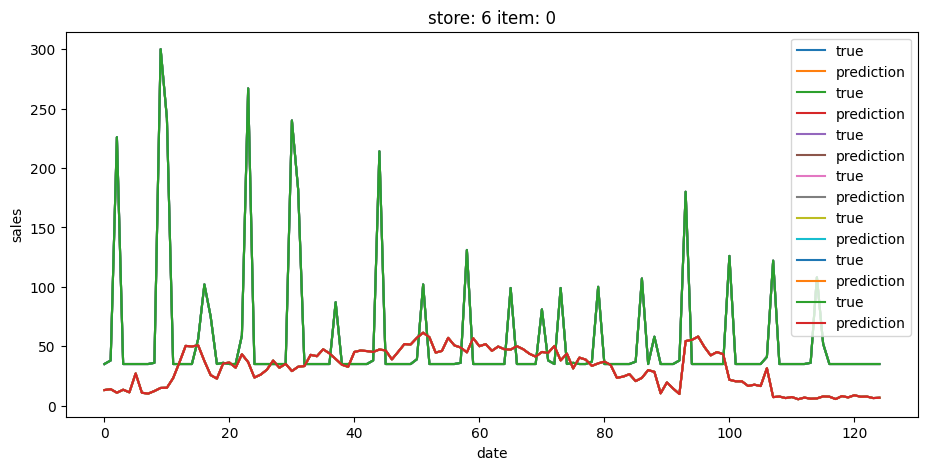

In [68]:
plt.figure(figsize=(11, 5))
plot_predictions(reverse_test, pred_test_all, 6, 0)

In [69]:
y_true = np.sum(reverse_test, axis=1)
pred = np.sum(pred_test_all, axis=1)


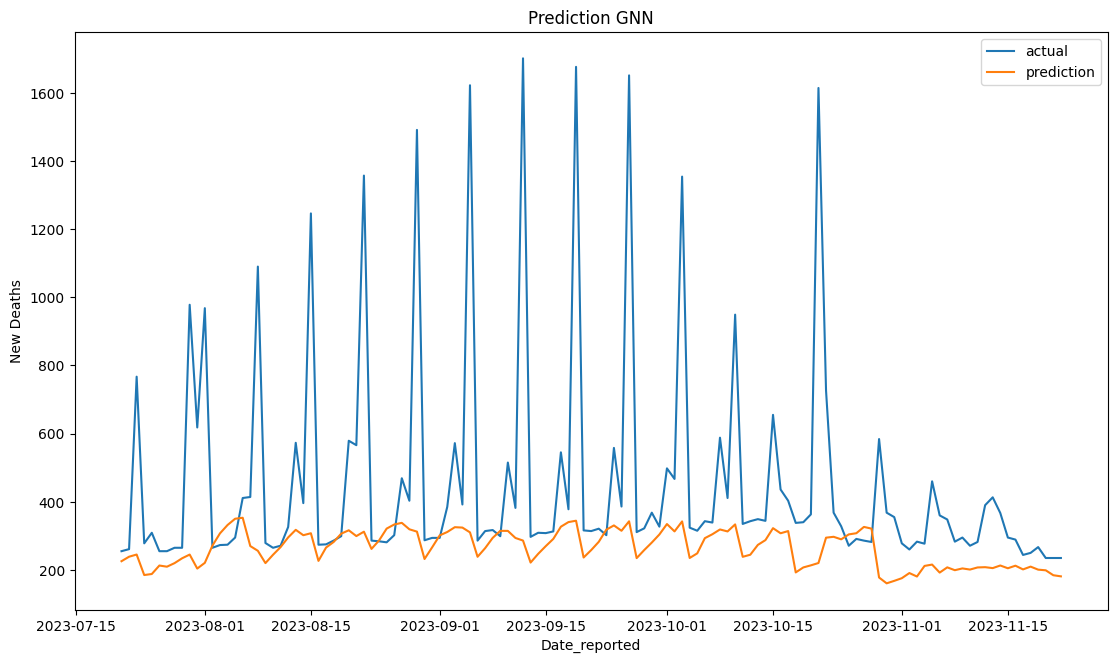

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(unique_dates[-len(pred):], y_true-1, label="actual")
ax.plot(unique_dates[-len(pred):], pred-1, label="prediction")
ax.set_title("Prediction GNN")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [71]:
print_evaluation_metrics(pred-1, y_true-1, np.sum(y_train, axis=1)-1)

Evaluation Metrics:
MSE: 142709.62
RMSE: 377.77
MAE: 199.70
MAPE: 30.18
SMAPE: 40.08
MASE: 0.11
